In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

plt.rcParams['font.family'] = "Arial" # 设置字体族为你指定的字体
DPI = 600

In [14]:
def get_df_dockq(model_list: list[str], result_dir: Path) -> pd.DataFrame:
    df_list = []
    for model_name in model_list:
        df_dockq = pd.read_csv(result_dir / f"dockq_{model_name}.csv")
        df_list.append(df_dockq)
    return pd.concat(df_list)

In [15]:
model_list = ["af3", "chai", "helix", "afm", "rfaa"]
results_dir = Path("../results")

df_dockq = get_df_dockq(model_list, results_dir)
df_dockq["model_name"] = df_dockq["job_id"].apply(lambda x: x.split("_")[2])
df_dockq["seed"] = df_dockq["job_id"].apply(lambda x: x.split("_")[4])
df_summary = pd.read_csv("../summary_jobs.csv")

# 读取difficult任务
df_difficult = pd.read_csv("/data/home/silong/paper/PepPCBench/results/af3_difficulty.csv")
df_difficult.rename(columns={"job_id": "job_name"}, inplace=True)
df_difficult.drop(labels=["model_name"], axis=1, inplace=True)
df_summary = pd.merge(df_summary, df_difficult, on="job_name", how="left")

In [16]:
df_dockq = pd.merge(df_dockq, df_summary, on="job_name", how="left")

# 过滤掉一些任务
df_new = pd.read_csv("/data/home/silong/paper/PepPCBench/results/job_summary.csv")
df_dockq = df_dockq[df_dockq["job_name"].isin(df_new["job_name"])]
print(len(df_dockq))

32325


In [17]:
def get_core_set(full_set: pd.DataFrame, clusters_test_path: Path = Path("../cluster2/clusters_test.pkl")):
    full_set = full_set.copy()
    with clusters_test_path.open("br") as f:
        clusters_test = pickle.load(f)

    def get_redundency(job_name):
        pdb_id = job_name.split("_")[0]
        if pdb_id in clusters_test["test_independent_set"]:
            return 0
        elif pdb_id in clusters_test["test_redundent_set"]:
            return 1
        elif pdb_id in clusters_test["train_redundent_set"]:
            return 2
        else:
            raise ValueError(f"{pdb_id} not in cluster test set")

    full_set["redundency"] = full_set["job_name"].apply(get_redundency)
    print(f"len(full_set): {len(full_set)}")
    print(
        f"Test Independant Set (N): {len(clusters_test['test_independent_set'])}\n"
        f"Test Redundent Set (N): {len(clusters_test['test_redundent_set'])}\n"
        f"Train Redundent Set (N): {len(clusters_test['train_redundent_set'])}\n"
    )
    train_set = full_set[full_set["redundency"] == 2].copy()
    test_set = full_set[~(full_set["redundency"] == 2)].copy()
    core_set = full_set[full_set["redundency"] == 0].copy()
    return full_set, train_set, test_set, core_set

In [18]:
fullset_df, trainset_df, testset_df, coreset_df = get_core_set(df_dockq)

len(full_set): 32325
Test Independant Set (N): 172
Test Redundent Set (N): 32
Train Redundent Set (N): 79



In [19]:
trainset_df["job_name"].unique(), testset_df["job_name"].unique(), coreset_df["job_name"].unique()

(array(['8cd3_A', '8ck5_B', '8ckc_B', '8cky_B', '8cmc_C', '8cmg_C',
        '8cqy_B', '8fub_B', '8i5e_P', '8igc_B', '8jbg_A', '8jbh_A',
        '8jis_P', '8okf_B', '8p43_P', '8p9o_P', '8p9w_B', '8p9x_B',
        '8pjg_C', '8pku_P', '8pkv_P', '8pwe_B', '8pwf_B', '8pwm_B',
        '8pxx_B', '8pz6_B', '8pz7_B', '8pz8_B', '8pz9_B', '8pzb_B',
        '8q1q_D', '8q1r_E', '8q7i_P', '8qxw_B', '8r10_C', '8r18_C',
        '8r1n_C', '8r1p_C', '8r1t_D', '8ral_C', '8rbu_C', '8rbv_C',
        '8rcv_C', '8ref_C', '8rng_C', '8rnh_C', '8rop_C', '8ryp_C',
        '8ryq_C', '8s8o_C', '8sbk_C', '8sf8_B', '8sgf_Z', '8sud_B',
        '8t32_B', '8t33_B', '8tut_B', '8tuv_B', '8u26_S', '8u2y_A',
        '8vpr_B', '8w6l_C', '8x8a_B', '8ym2_B', '9atn_B', '9ck0_B',
        '9cwn_B', '9dw6_C', '9eyr_B', '9ez1_B', '9ez2_B', '9f7w_B',
        '9f7x_B', '9gag_B', '8jqt_C', '8kb1_C', '8wo9_C'], dtype=object),
 array(['8c5l_C', '8ccz_C', '8cir_C', '8cis_B', '8cm9_E', '8cmd_C',
        '8cme_C', '8cmi_C', '8cob_F', '8fu

In [20]:
len(fullset_df[fullset_df["model_name"] == "af3"]) / 25, len(trainset_df[trainset_df["model_name"] == "af3"]) / 25, len(testset_df[testset_df["model_name"] == "af3"]) / 25, len(coreset_df[coreset_df["model_name"] == "af3"]) / 25

(260.0, 77.0, 183.0, 153.0)

In [21]:
len(fullset_df["job_name"].unique()), len(df_new)

(260, 261)

In [25]:
for model_name in model_list:
    _df = fullset_df[fullset_df["model_name"] == model_name]
    n_total = len(_df)
    _df = _df[_df["LRMSD"] < 10]
    print(f"{model_name}: {len(_df)} / {n_total}, ({len(_df) / n_total:.2%})")

af3: 5179 / 6500, (79.68%)
chai: 4895 / 6500, (75.31%)
helix: 5049 / 6500, (77.68%)
afm: 5088 / 6500, (78.28%)
rfaa: 3102 / 6325, (49.04%)


In [22]:
rename_dict = {
    "af3": "AF3",
    "chai": "Chai-1",
    "helix": "HF3",
    "afm": "AFM",
    "rfaa": "RFAA"
}

In [23]:
def plot_dockq_with_pep_len(
    df: pd.DataFrame,
    metric="DockQ",
    seed_mode=False,
    len_seg=["5-10", "10-15", "15-20", "20-30"],
    y_ticks = False
):
    """
    绘制基于不同模型的 DockQ 分布图，并根据指定的长度区间划分数据。

    参数:
    - df: 包含模型名称、任务名称、种子值、长度信息和性能指标的数据框
    - metric: 用于绘图的性能指标，默认为 "DockQ"
    - seed_mode: 是否按种子值计算平均值，如果为True，则基于每个种子的指标计算均值
    - len_seg: 长度区间，用于分组，默认为["5-10", "10-15", "15-30"]
    """

    # 根据 metric 确定排序方式
    ascending = metric in ["DockQ", "F1", "fnat"]

    # 将长度区间划分为数字范围
    len_ranges = []
    for seg in len_seg:
        start, end = map(int, seg.split("-"))
        len_ranges.append((start, end))

    # 存储每个模型的结果
    result_list = []

    # 分组并计算指标
    for model_name, model_group in df.groupby("model_name"):
        for job_name, job_group in model_group.groupby("job_name"):
            # 按长度区间分组
            for start, end in len_ranges:
                # 筛选出长度在当前区间内的样本
                length_group = job_group[
                    (job_group["peptide_chain_len"] >= start) & (job_group["peptide_chain_len"] < end)
                ]

                # 如果有数据才进行处理
                if not length_group.empty:
                    result = {
                        "model_name": rename_dict[model_name],
                        "job_name": job_name,
                        "length_range": f"{start}-{end}",
                    }

                    if seed_mode:
                        # 按种子值处理数据并计算均值
                        score_seed_list = [
                            seed_group[metric].sort_values(ascending=ascending).iloc[0]
                            for _, seed_group in length_group.groupby("seed")
                        ]
                        result[metric] = np.mean(score_seed_list)
                    else:
                        # 直接取第一条排序后的指标值
                        result[metric] = (
                            length_group[metric]
                            .sort_values(ascending=ascending)
                            .iloc[0]
                        )

                    result_list.append(result)

    # 将结果转为 DataFrame
    result_df = pd.DataFrame(result_list)
    print(len(result_df))

    for seg in len_seg:
        seg_df = result_df[result_df['length_range'] == seg]
        print(f"Statistics for length segment {seg}:")
        print(f"Mean {metric}: {seg_df[metric].mean()}")
        print(f"Median {metric}: {seg_df[metric].median()}")
        print(f"Min {metric}: {seg_df[metric].min()}")
        print(f"Max {metric}: {seg_df[metric].max()}")
        print("-----------")

    # 确保长度区间按照顺序排列
    result_df["length_range"] = pd.Categorical(
        result_df["length_range"], categories=len_seg, ordered=True
    )

    # 计算每个模型的统计值：均值、最小值、最大值和中位数
    grouped = result_df.groupby("model_name")[metric]
    statistics = grouped.agg(["mean", "min", "max", "median"])

    for seg in len_seg:
        seg_df = result_df[result_df['length_range'] == seg]
        for model in statistics.index:  
            print(model)
            seg_df_model = seg_df[seg_df['model_name'] == model]
            print(f"Mean {metric}: {seg_df_model[metric].mean()}")
            print(f"Median {metric}: {seg_df_model[metric].median()}")
            print(f"Min {metric}: {seg_df_model[metric].min()}")
            print(f"Max {metric}: {seg_df_model[metric].max()}")
            print("-----------")

    # 将均值加入 DataFrame 并按均值排序
    result_df["mean_value"] = result_df["model_name"].map(statistics["mean"])
    result_df = result_df.sort_values(by="mean_value", ascending=not ascending)

    # 绘制箱型图
    fig, ax = plt.subplots(figsize=(4, 4), dpi=600)
    sns.boxplot(
        data=result_df,
        x="model_name",
        y=metric,
        hue="length_range",
        palette="Set3",
        showmeans=True,
        ax=ax,
        boxprops=dict(alpha=1, linewidth=1.5),
        whiskerprops=dict(alpha=1, linewidth=1.5),
        capprops=dict(alpha=1, linewidth=1.5),
        meanprops=dict(markersize=4, linewidth=1.5),
        flierprops=dict(markersize=4, linewidth=1.5),
        medianprops=dict(linewidth=1.5, alpha=1),
    )

    # 设置图表标签
    # ax.set_xlabel("Model")
    # ax.set_ylabel(f"{metric}")
    # ax.set_title(f"DockQ distribution by Length Segments")

    # 旋转x轴标签
    # plt.xticks(rotation=45)

    # 设置图例位置
    # plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), borderaxespad=0)
    plt.legend().remove()
    plt.xlabel("")
    plt.ylabel("")
    if not y_ticks:
        plt.yticks([])
    # 显示图形
    # fig.patch.set_edgecolor('black')
    # fig.patch.set_linewidth(2.0)
    plt.tight_layout()
    plt.show()

1293
Statistics for length segment 5-10:
Mean DockQ: 0.48204373427017316
Median DockQ: 0.5657451386354623
Min DockQ: 0.0042238692416666
Max DockQ: 0.9533943516548024
-----------
Statistics for length segment 10-15:
Mean DockQ: 0.4341811936270122
Median DockQ: 0.36857201481197666
Min DockQ: 0.0029222957553897
Max DockQ: 0.9575864028214164
-----------
Statistics for length segment 15-20:
Mean DockQ: 0.3271754618261285
Median DockQ: 0.13172031503477136
Min DockQ: 0.0049545386985102
Max DockQ: 0.9501851920720648
-----------
Statistics for length segment 20-30:
Mean DockQ: 0.405971658250308
Median DockQ: 0.4048618062453074
Min DockQ: 0.0031309114919034
Max DockQ: 0.9615410627417076
-----------
AF3
Mean DockQ: 0.5967203254200244
Median DockQ: 0.7892501832453075
Min DockQ: 0.0068244068407983
Max DockQ: 0.9477377745478802
-----------
AFM
Mean DockQ: 0.5453732887301809
Median DockQ: 0.6315048541260246
Min DockQ: 0.0106198456499828
Max DockQ: 0.946827617709549
-----------
Chai-1
Mean DockQ: 0.58

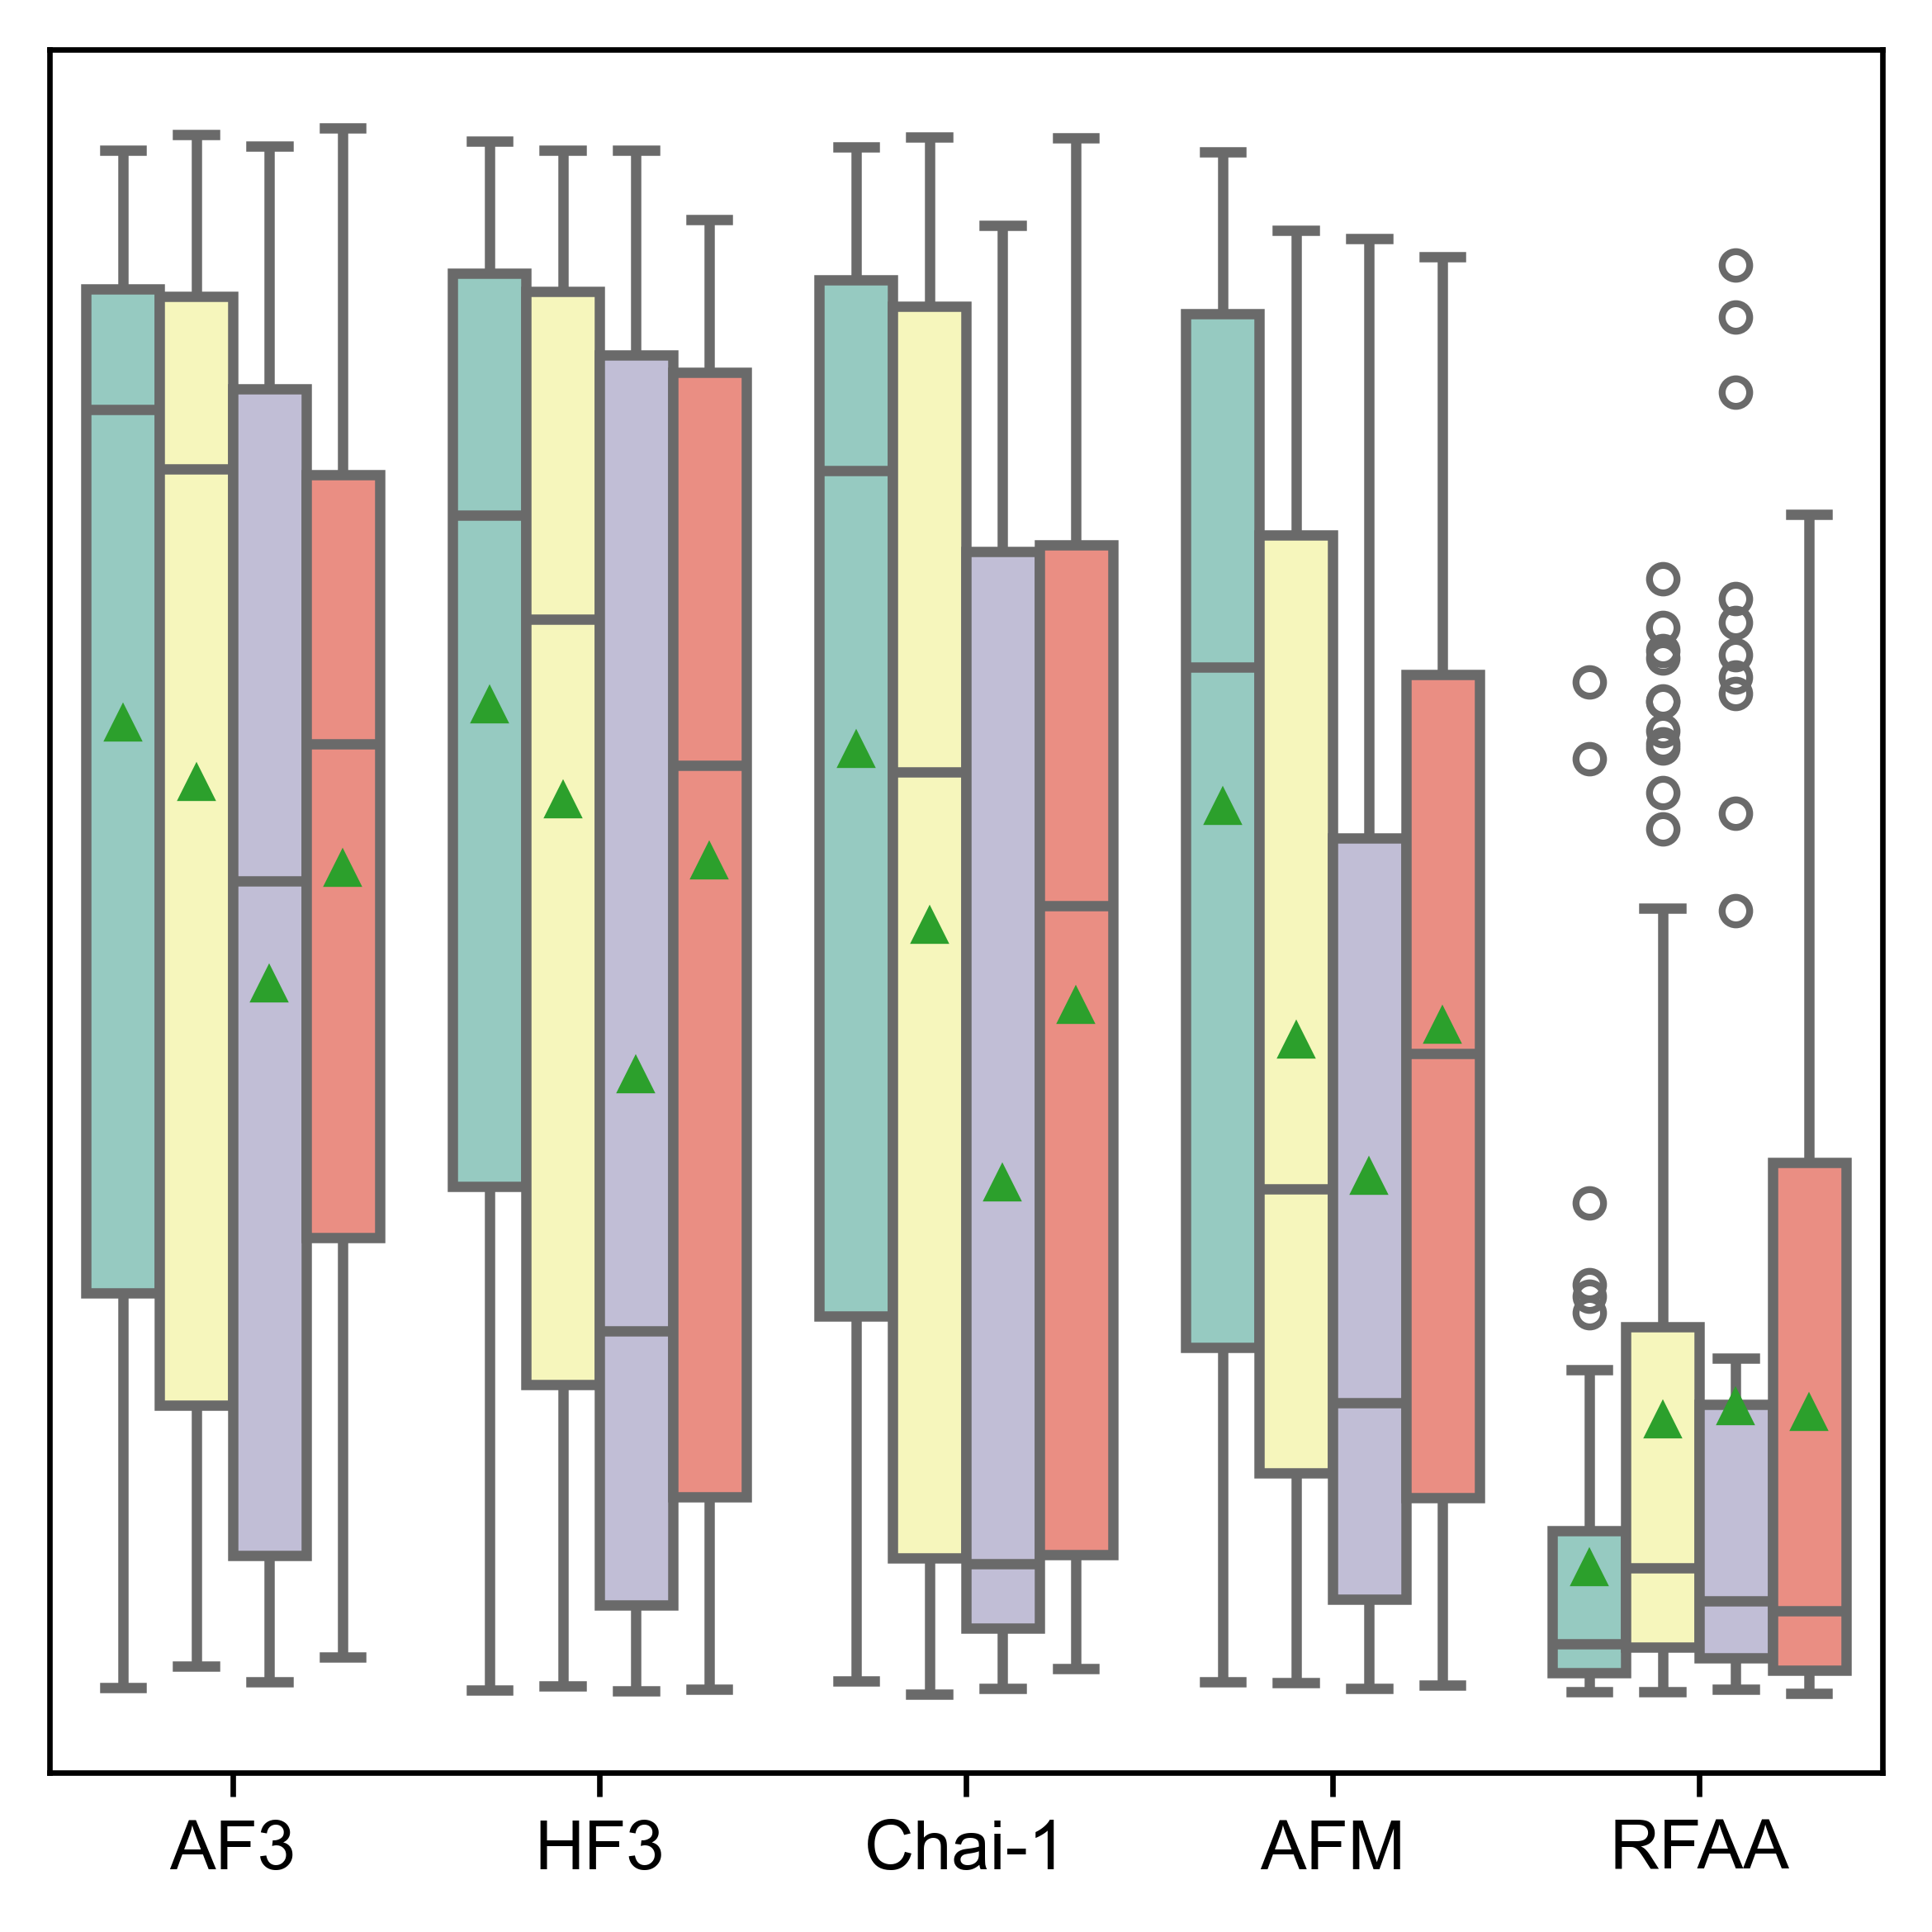

In [12]:
plot_dockq_with_pep_len(fullset_df, "DockQ", y_ticks=False)

1293
Statistics for length segment 5-10:
Mean LRMSD: 13.032113887060504
Median LRMSD: 5.210569923828379
Min LRMSD: 0.5448981317522593
Max LRMSD: 82.27097016902185
-----------
Statistics for length segment 10-15:
Mean LRMSD: 12.294797909416426
Median LRMSD: 6.809957630913854
Min LRMSD: 0.5735722334153196
Max LRMSD: 98.43018418995248
-----------
Statistics for length segment 15-20:
Mean LRMSD: 17.395340926672127
Median LRMSD: 14.576523181492837
Min LRMSD: 0.5294356623609837
Max LRMSD: 75.74016588752998
-----------
Statistics for length segment 20-30:
Mean LRMSD: 14.541091663110658
Median LRMSD: 7.312869724119251
Min LRMSD: 0.5735124091554028
Max LRMSD: 94.3385282654762
-----------
AF3
Mean LRMSD: 8.675071726558167
Median LRMSD: 2.125070409449789
Min LRMSD: 0.5519654541568919
Max LRMSD: 63.907314079291744
-----------
AFM
Mean LRMSD: 8.239671585990102
Median LRMSD: 3.1635008094920143
Min LRMSD: 0.6295418311702363
Max LRMSD: 50.53624850397347
-----------
Chai-1
Mean LRMSD: 8.290787501306914

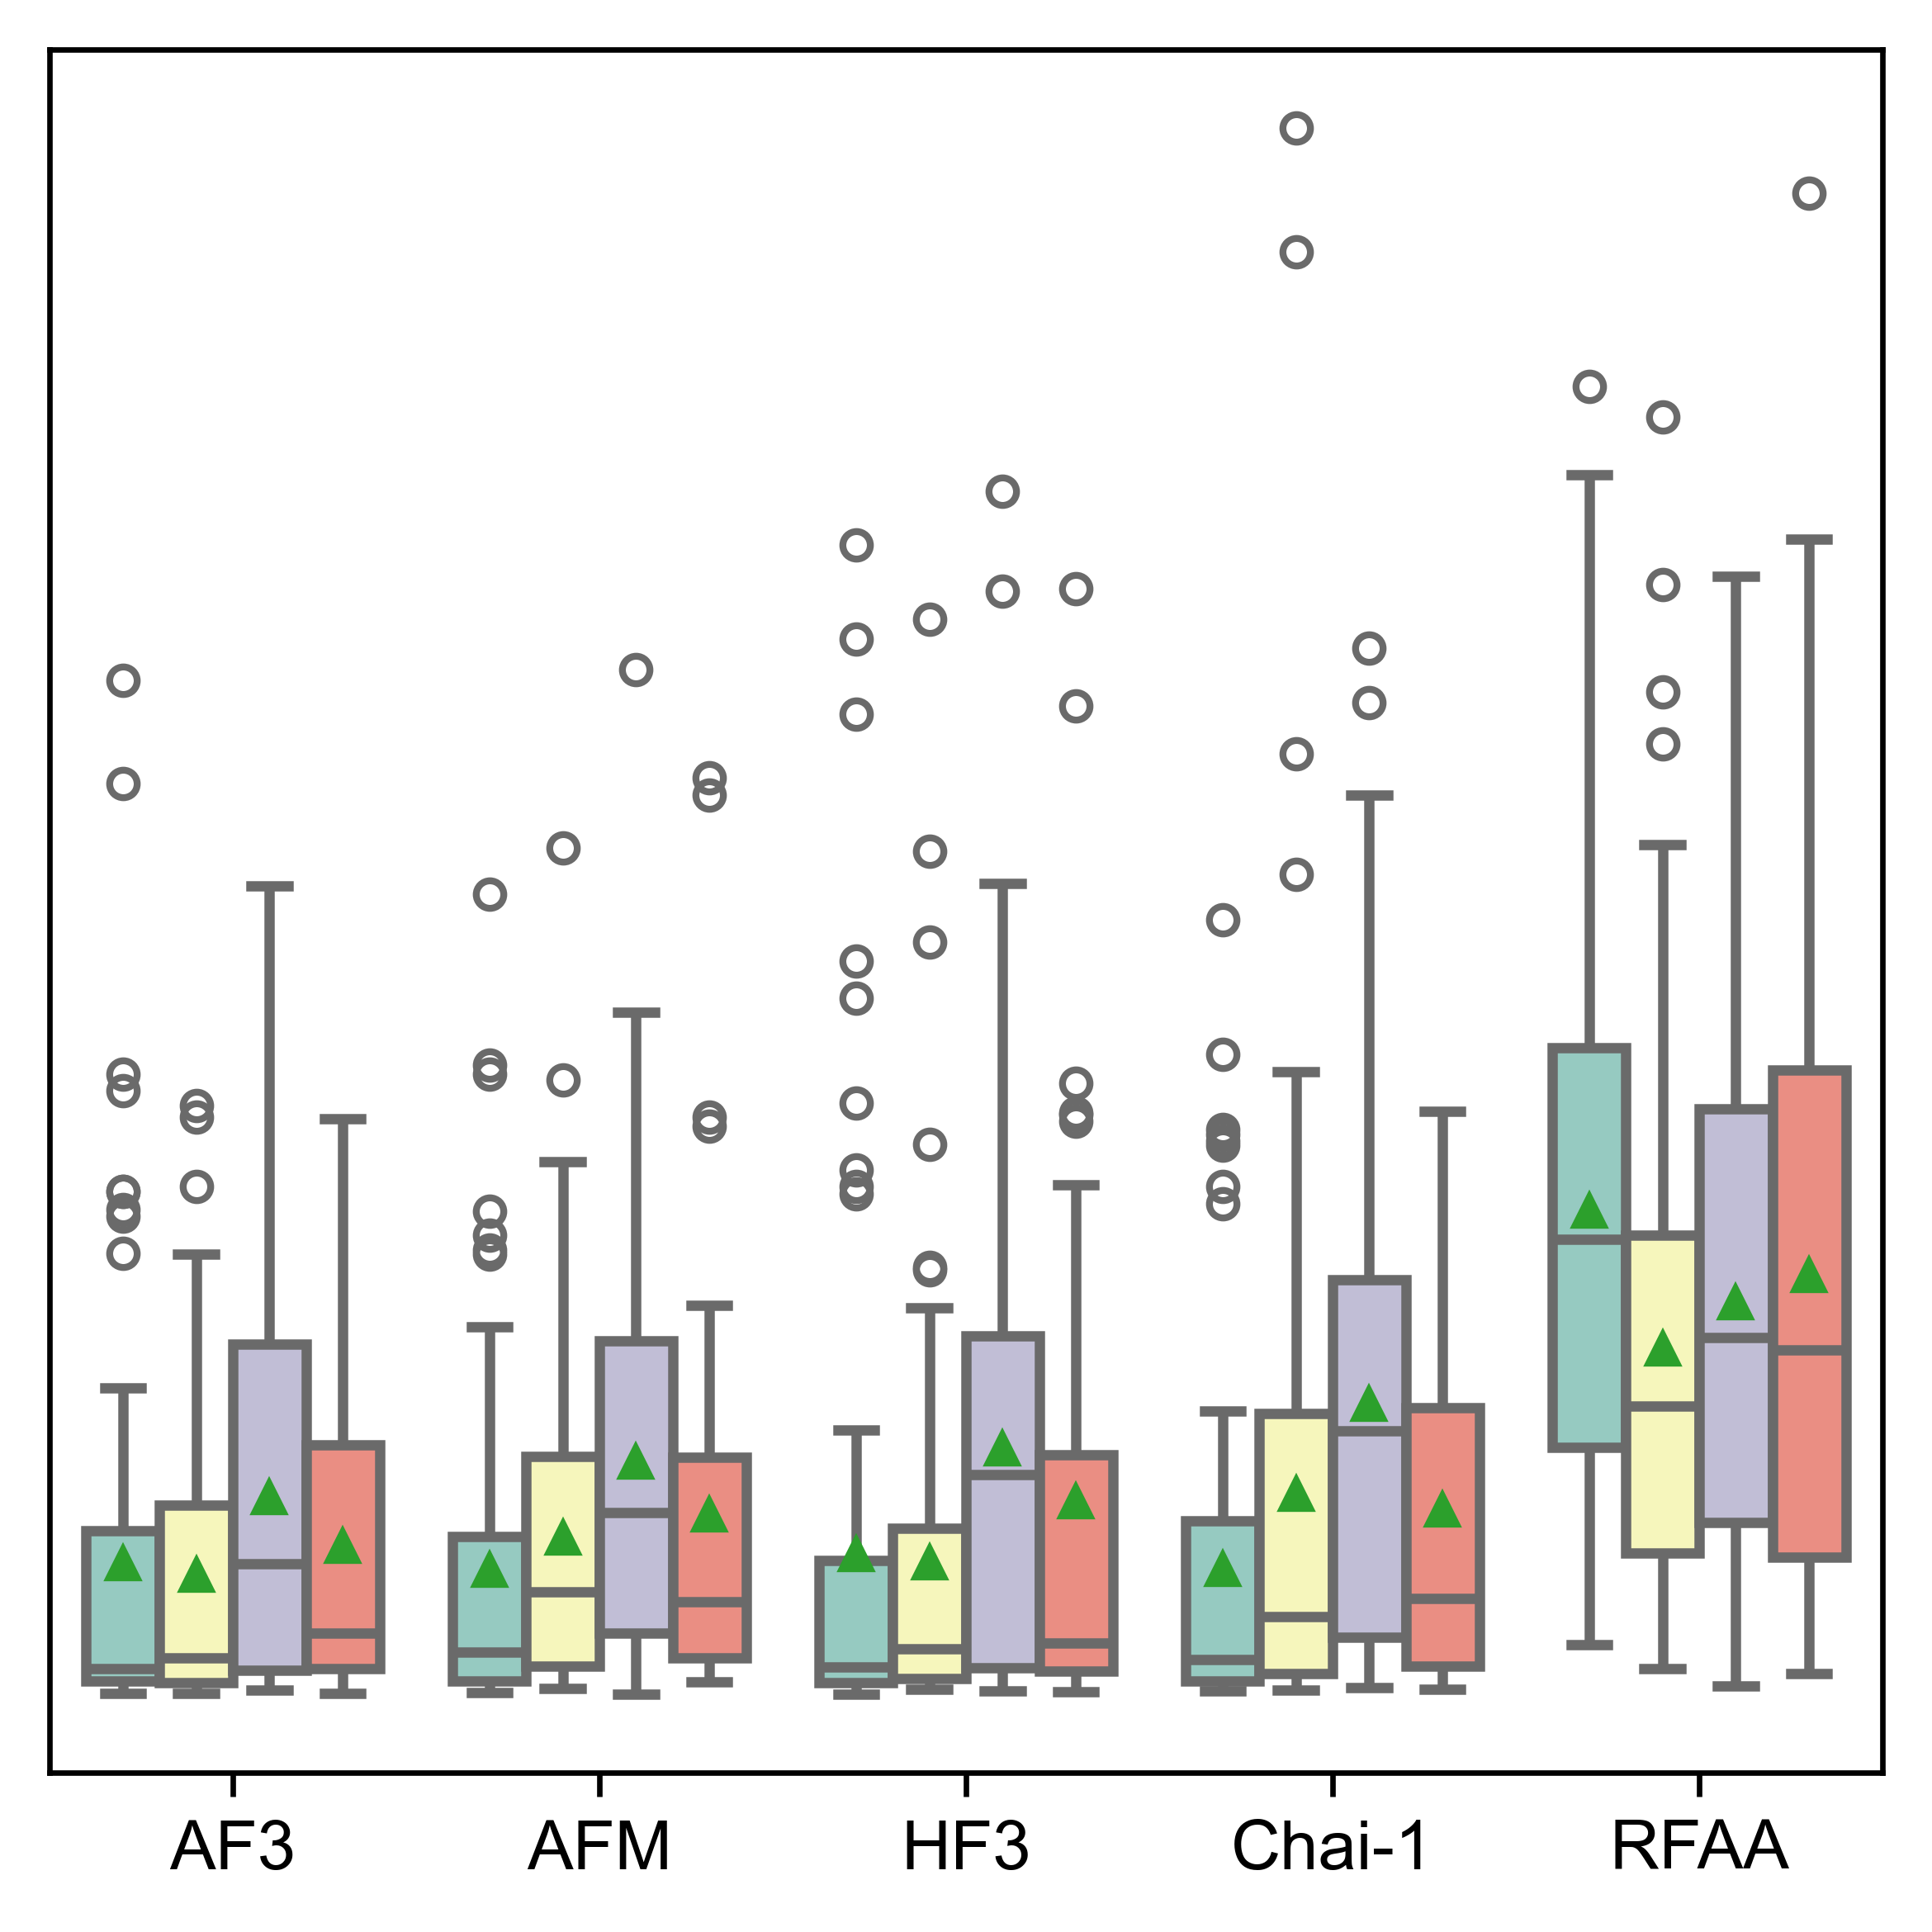

In [24]:
plot_dockq_with_pep_len(fullset_df, "LRMSD", y_ticks=False)

1293
Statistics for length segment 5-10:
Mean fnat: 0.4276083497484152
Median fnat: 0.5882352941176471
Min fnat: 0.0
Max fnat: 0.95
-----------
Statistics for length segment 10-15:
Mean fnat: 0.3697914075956423
Median fnat: 0.2532051282051282
Min fnat: 0.0
Max fnat: 0.9705882352941176
-----------
Statistics for length segment 15-20:
Mean fnat: 0.2766830278423934
Median fnat: 0.0357142857142857
Min fnat: 0.0
Max fnat: 0.9285714285714286
-----------
Statistics for length segment 20-30:
Mean fnat: 0.36926896037540907
Median fnat: 0.3875
Min fnat: 0.0
Max fnat: 0.9473684210526316
-----------
AF3
Mean fnat: 0.5569587081085331
Median fnat: 0.7419354838709677
Min fnat: 0.0
Max fnat: 0.95
-----------
AFM
Mean fnat: 0.4733539739230709
Median fnat: 0.625
Min fnat: 0.0
Max fnat: 0.8809523809523809
-----------
Chai-1
Mean fnat: 0.5145979573803947
Median fnat: 0.6481481481481481
Min fnat: 0.0
Max fnat: 0.9047619047619048
-----------
HF3
Mean fnat: 0.560639702019344
Median fnat: 0.7058823529411765
M

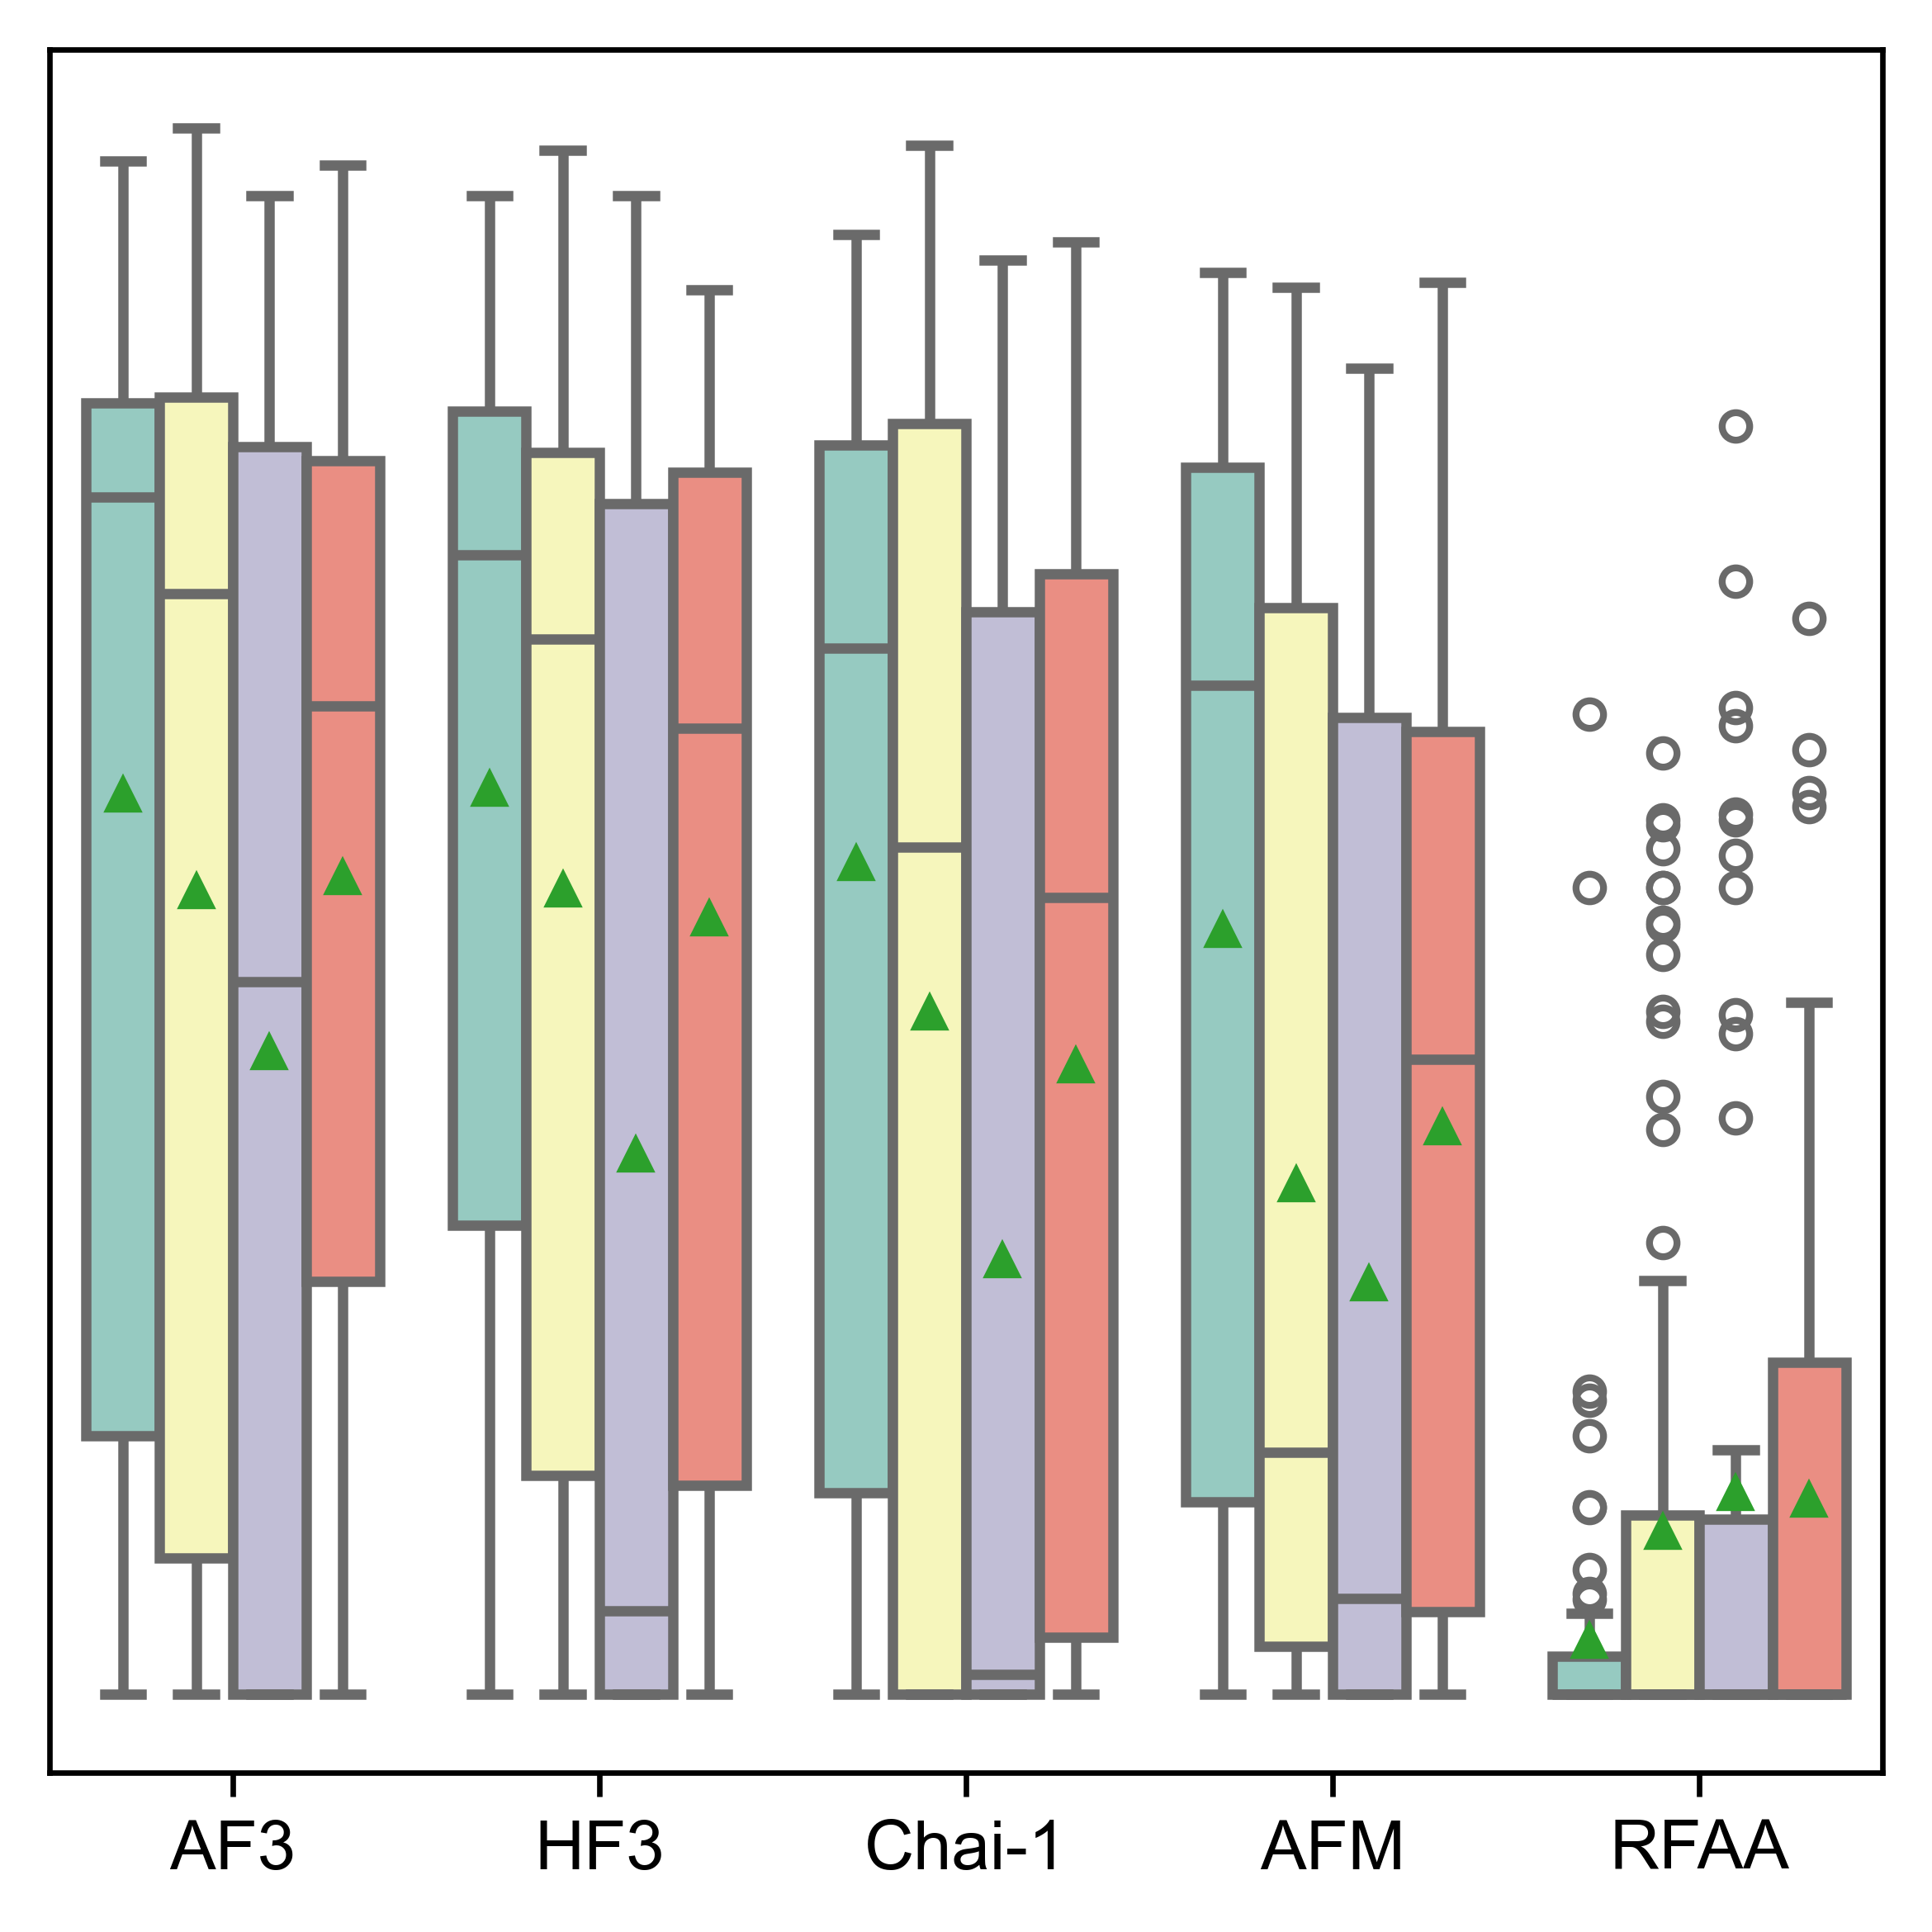

In [25]:
plot_dockq_with_pep_len(fullset_df, "fnat", y_ticks=False)

In [26]:
def plot_dockq_with_pep_difficulty(
    df: pd.DataFrame,
    metric="DockQ",
    seed_mode=False,
    difficulty_order=["Easy", "Medium", "Difficult"],
    y_ticks = False
):
    """
    绘制不同模型在不同结构预测难度（Easy/Medium/Hard）上的 DockQ 分布图。
    """

    # 判断排序方式（DockQ 越高越好）
    ascending = metric in ["DockQ", "F1", "fnat"]

    result_list = []

    # 分组计算
    for model_name, model_group in df.groupby("model_name"):
        for job_name, job_group in model_group.groupby("job_name"):
            for diff in difficulty_order:
                subset = job_group[job_group["difficulty"] == diff]
                if not subset.empty:
                    result = {
                        "model_name": rename_dict[model_name],
                        "job_name": job_name,
                        "difficulty": diff,
                    }

                    if seed_mode:
                        score_seed_list = [
                            seed_group[metric].sort_values(ascending=ascending).iloc[0]
                            for _, seed_group in subset.groupby("seed")
                        ]
                        result[metric] = np.mean(score_seed_list)
                    else:
                        result[metric] = subset[metric].sort_values(ascending=ascending).iloc[0]

                    result_list.append(result)

    # 转 DataFrame
    result_df = pd.DataFrame(result_list)

    # 控制 difficulty 显示顺序
    result_df["difficulty"] = pd.Categorical(
        result_df["difficulty"], categories=difficulty_order, ordered=True
    )

    # 模型排序（按整体平均性能）
    model_means = result_df.groupby("model_name")[metric].mean().sort_values(ascending=not ascending)
    result_df["model_name"] = pd.Categorical(
        result_df["model_name"], categories=model_means.index, ordered=True
    )

    # 输出模型统计信息
    stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])
    for model in stats.index:
        print(
            f"Model: {model}, "
            f"Mean {metric}: {stats.loc[model, 'mean']:.4f}, "
            f"Min: {stats.loc[model, 'min']:.4f}, "
            f"Max: {stats.loc[model, 'max']:.4f}, "
            f"Median: {stats.loc[model, 'median']:.4f}"
        )
    for diff in difficulty_order:
        seg_df = result_df[result_df['difficulty'] == diff]
        for model in stats.index:  
            print(model)
            seg_df_model = seg_df[seg_df['model_name'] == model]
            print(f"Mean {metric}: {seg_df_model[metric].mean()}")
            print(f"Median {metric}: {seg_df_model[metric].median()}")
            print(f"Min {metric}: {seg_df_model[metric].min()}")
            print(f"Max {metric}: {seg_df_model[metric].max()}")
            print("-----------")

    # 绘图
    fig, ax = plt.subplots(figsize=(4, 4), dpi=600)
    sns.boxplot(
        data=result_df,
        x="model_name",
        y=metric,
        hue="difficulty",
        hue_order=difficulty_order,
        palette="Set3",  # 更清爽，或自定义
        showmeans=True,
        ax=ax,
        boxprops=dict(alpha=1),
        whiskerprops=dict(alpha=1),
        capprops=dict(alpha=1),
        meanprops=dict(markersize=4),
        flierprops=dict(markersize=4),
    )

    # 美化图表（你可以解注释来加标签）
    # plt.legend(title="Difficulty", loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.legend().remove()
    plt.xlabel("")
    plt.ylabel("")
    for spine in ax.spines.values():
        spine.set_visible(True)
    if not y_ticks:
        plt.yticks([])
    # fig.patch.set_edgecolor('black')
    # fig.patch.set_linewidth(2.0)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1199686/3118983565.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


Model: AF3, Mean DockQ: 0.5345, Min: 0.0068, Max: 0.9615, Median: 0.6363
Model: HF3, Mean DockQ: 0.5224, Min: 0.0050, Max: 0.9534, Median: 0.5996
Model: Chai-1, Mean DockQ: 0.4600, Min: 0.0029, Max: 0.9561, Median: 0.5087
Model: AFM, Mean DockQ: 0.4256, Min: 0.0065, Max: 0.9468, Median: 0.3486
Model: RFAA, Mean DockQ: 0.1466, Min: 0.0031, Max: 0.8778, Median: 0.0613
AF3
Mean DockQ: 0.5554734893811983
Median DockQ: 0.7095869510602751
Min DockQ: 0.0068244068407983
Max DockQ: 0.9615410627417076
-----------
HF3
Mean DockQ: 0.5381021933705914
Median DockQ: 0.6508885079820789
Min DockQ: 0.0049545386985102
Max DockQ: 0.9533943516548024
-----------
Chai-1
Mean DockQ: 0.47638113697821105
Median DockQ: 0.5502265052297535
Min DockQ: 0.0029222957553897
Max DockQ: 0.9561209262870146
-----------
AFM
Mean DockQ: 0.439819164027782
Median DockQ: 0.3953414817330267
Min DockQ: 0.0065218666160421
Max DockQ: 0.946827617709549
-----------
RFAA
Mean DockQ: 0.14764815734227316
Median DockQ: 0.0596895741773368

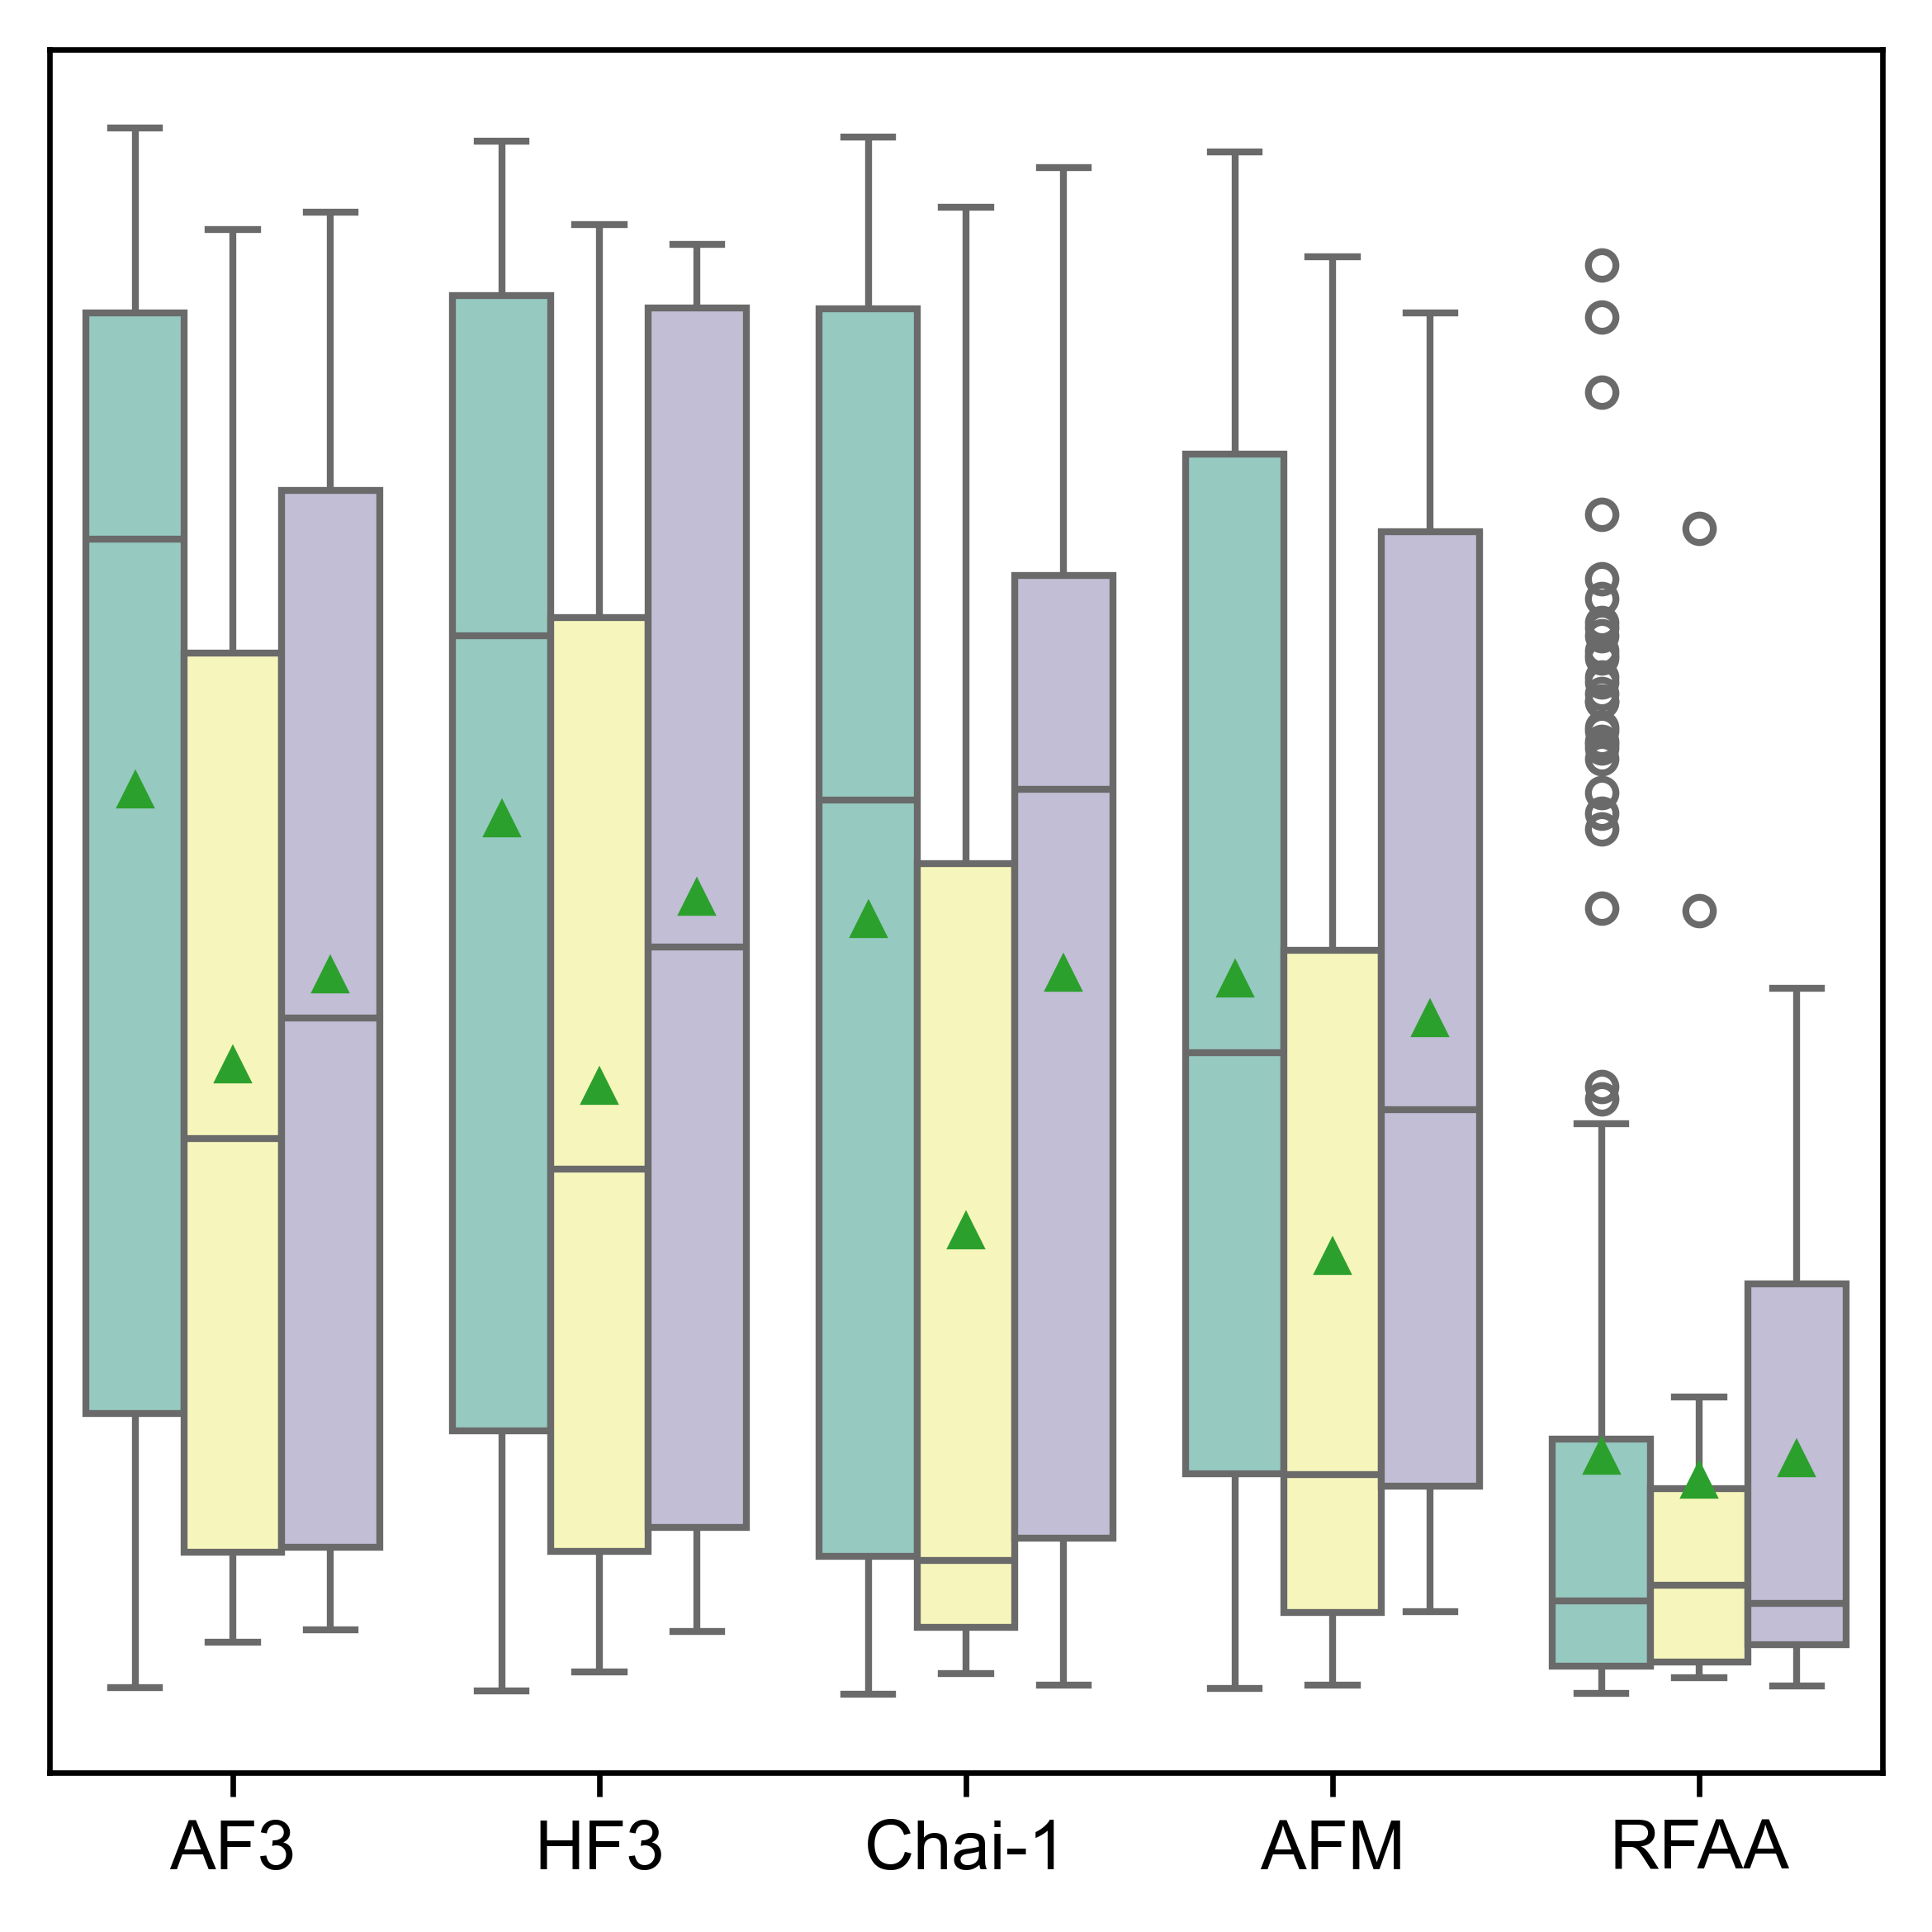

In [27]:
plot_dockq_with_pep_difficulty(fullset_df, "DockQ")

/tmp/ipykernel_4095657/3118983565.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


Model: AF3, Mean LRMSD: 9.5203, Min: 0.5520, Max: 63.9073, Median: 3.1850
Model: AFM, Mean LRMSD: 10.9929, Min: 0.5294, Max: 64.5621, Median: 6.6161
Model: HF3, Mean LRMSD: 11.0687, Min: 0.5449, Max: 75.7402, Median: 3.7294
Model: Chai-1, Mean LRMSD: 12.7799, Min: 0.7063, Max: 98.4302, Median: 6.1574
Model: RFAA, Mean LRMSD: 25.9798, Min: 1.0211, Max: 94.3385, Median: 22.4962
AF3
Mean LRMSD: 9.24892208372209
Median LRMSD: 2.586620956308686
Min LRMSD: 0.5519654541568919
Max LRMSD: 63.907314079291744
-----------
AFM
Mean LRMSD: 10.716975116693888
Median LRMSD: 6.068409035844433
Min LRMSD: 0.5294356623609837
Max LRMSD: 64.56212219359536
-----------
HF3
Mean LRMSD: 10.92575871346976
Median LRMSD: 3.2379539456248647
Min LRMSD: 0.5448981317522593
Max LRMSD: 75.74016588752998
-----------
Chai-1
Mean LRMSD: 12.51418664404915
Median LRMSD: 5.504674624217662
Min LRMSD: 0.7062566458690409
Max LRMSD: 98.43018418995248
-----------
RFAA
Mean LRMSD: 26.424689236740345
Median LRMSD: 22.642182941642048

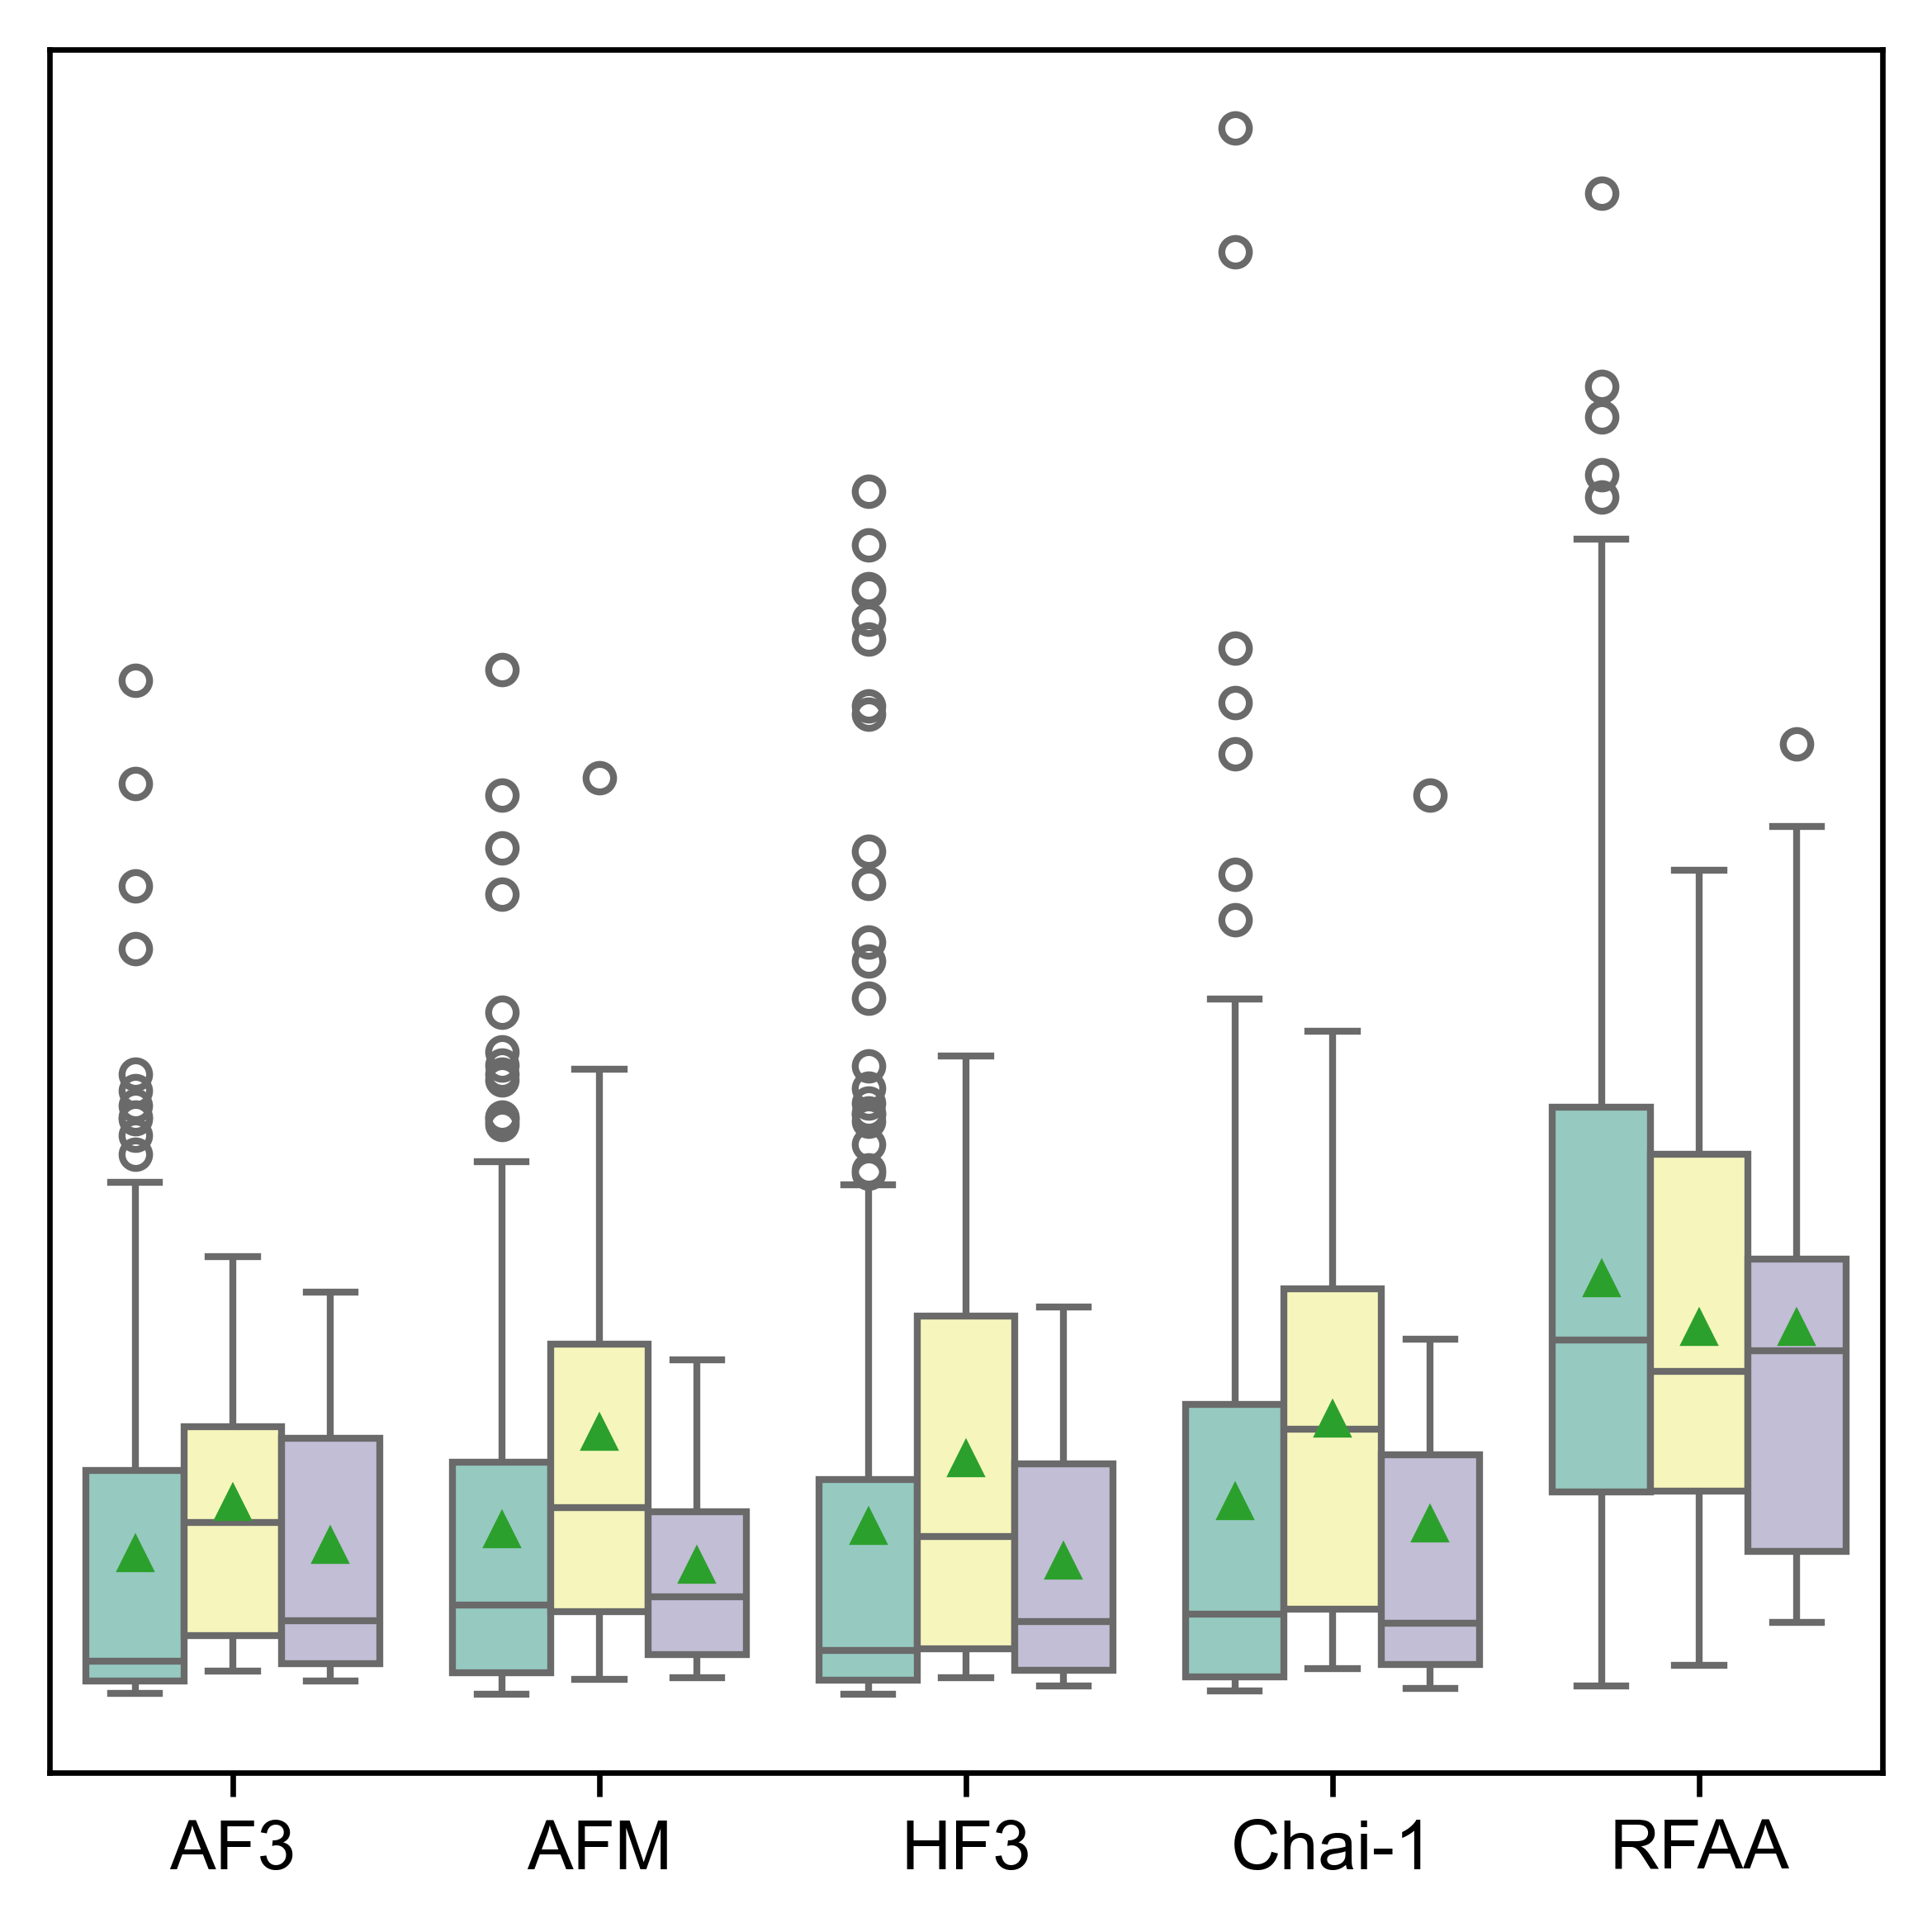

In [26]:
plot_dockq_with_pep_difficulty(fullset_df, "LRMSD")

/tmp/ipykernel_4095657/3118983565.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


Model: AF3, Mean fnat: 0.4154, Min: 0.0000, Max: 0.9706, Median: 0.4286
Model: HF3, Mean fnat: 0.3969, Min: 0.0000, Max: 0.9048, Median: 0.4048
Model: Chai-1, Mean fnat: 0.3234, Min: 0.0000, Max: 0.9231, Median: 0.1562
Model: AFM, Mean fnat: 0.2776, Min: 0.0000, Max: 0.8750, Median: 0.1250
Model: RFAA, Mean fnat: 0.0668, Min: 0.0000, Max: 0.7857, Median: 0.0000
AF3
Mean fnat: 0.4333583003835919
Median fnat: 0.5
Min fnat: 0.0
Max fnat: 0.9285714285714286
-----------
HF3
Mean fnat: 0.4057140007235654
Median fnat: 0.4090909090909091
Min fnat: 0.0
Max fnat: 0.9047619047619048
-----------
Chai-1
Mean fnat: 0.3344813518223231
Median fnat: 0.17914438502673796
Min fnat: 0.0
Max fnat: 0.9230769230769232
-----------
AFM
Mean fnat: 0.28093075529916883
Median fnat: 0.1273148148148148
Min fnat: 0.0
Max fnat: 0.875
-----------
RFAA
Mean fnat: 0.06620302536233816
Median fnat: 0.0
Min fnat: 0.0
Max fnat: 0.7857142857142857
-----------
AF3
Mean fnat: 0.368820934449946
Median fnat: 0.3333333333333333
Mi

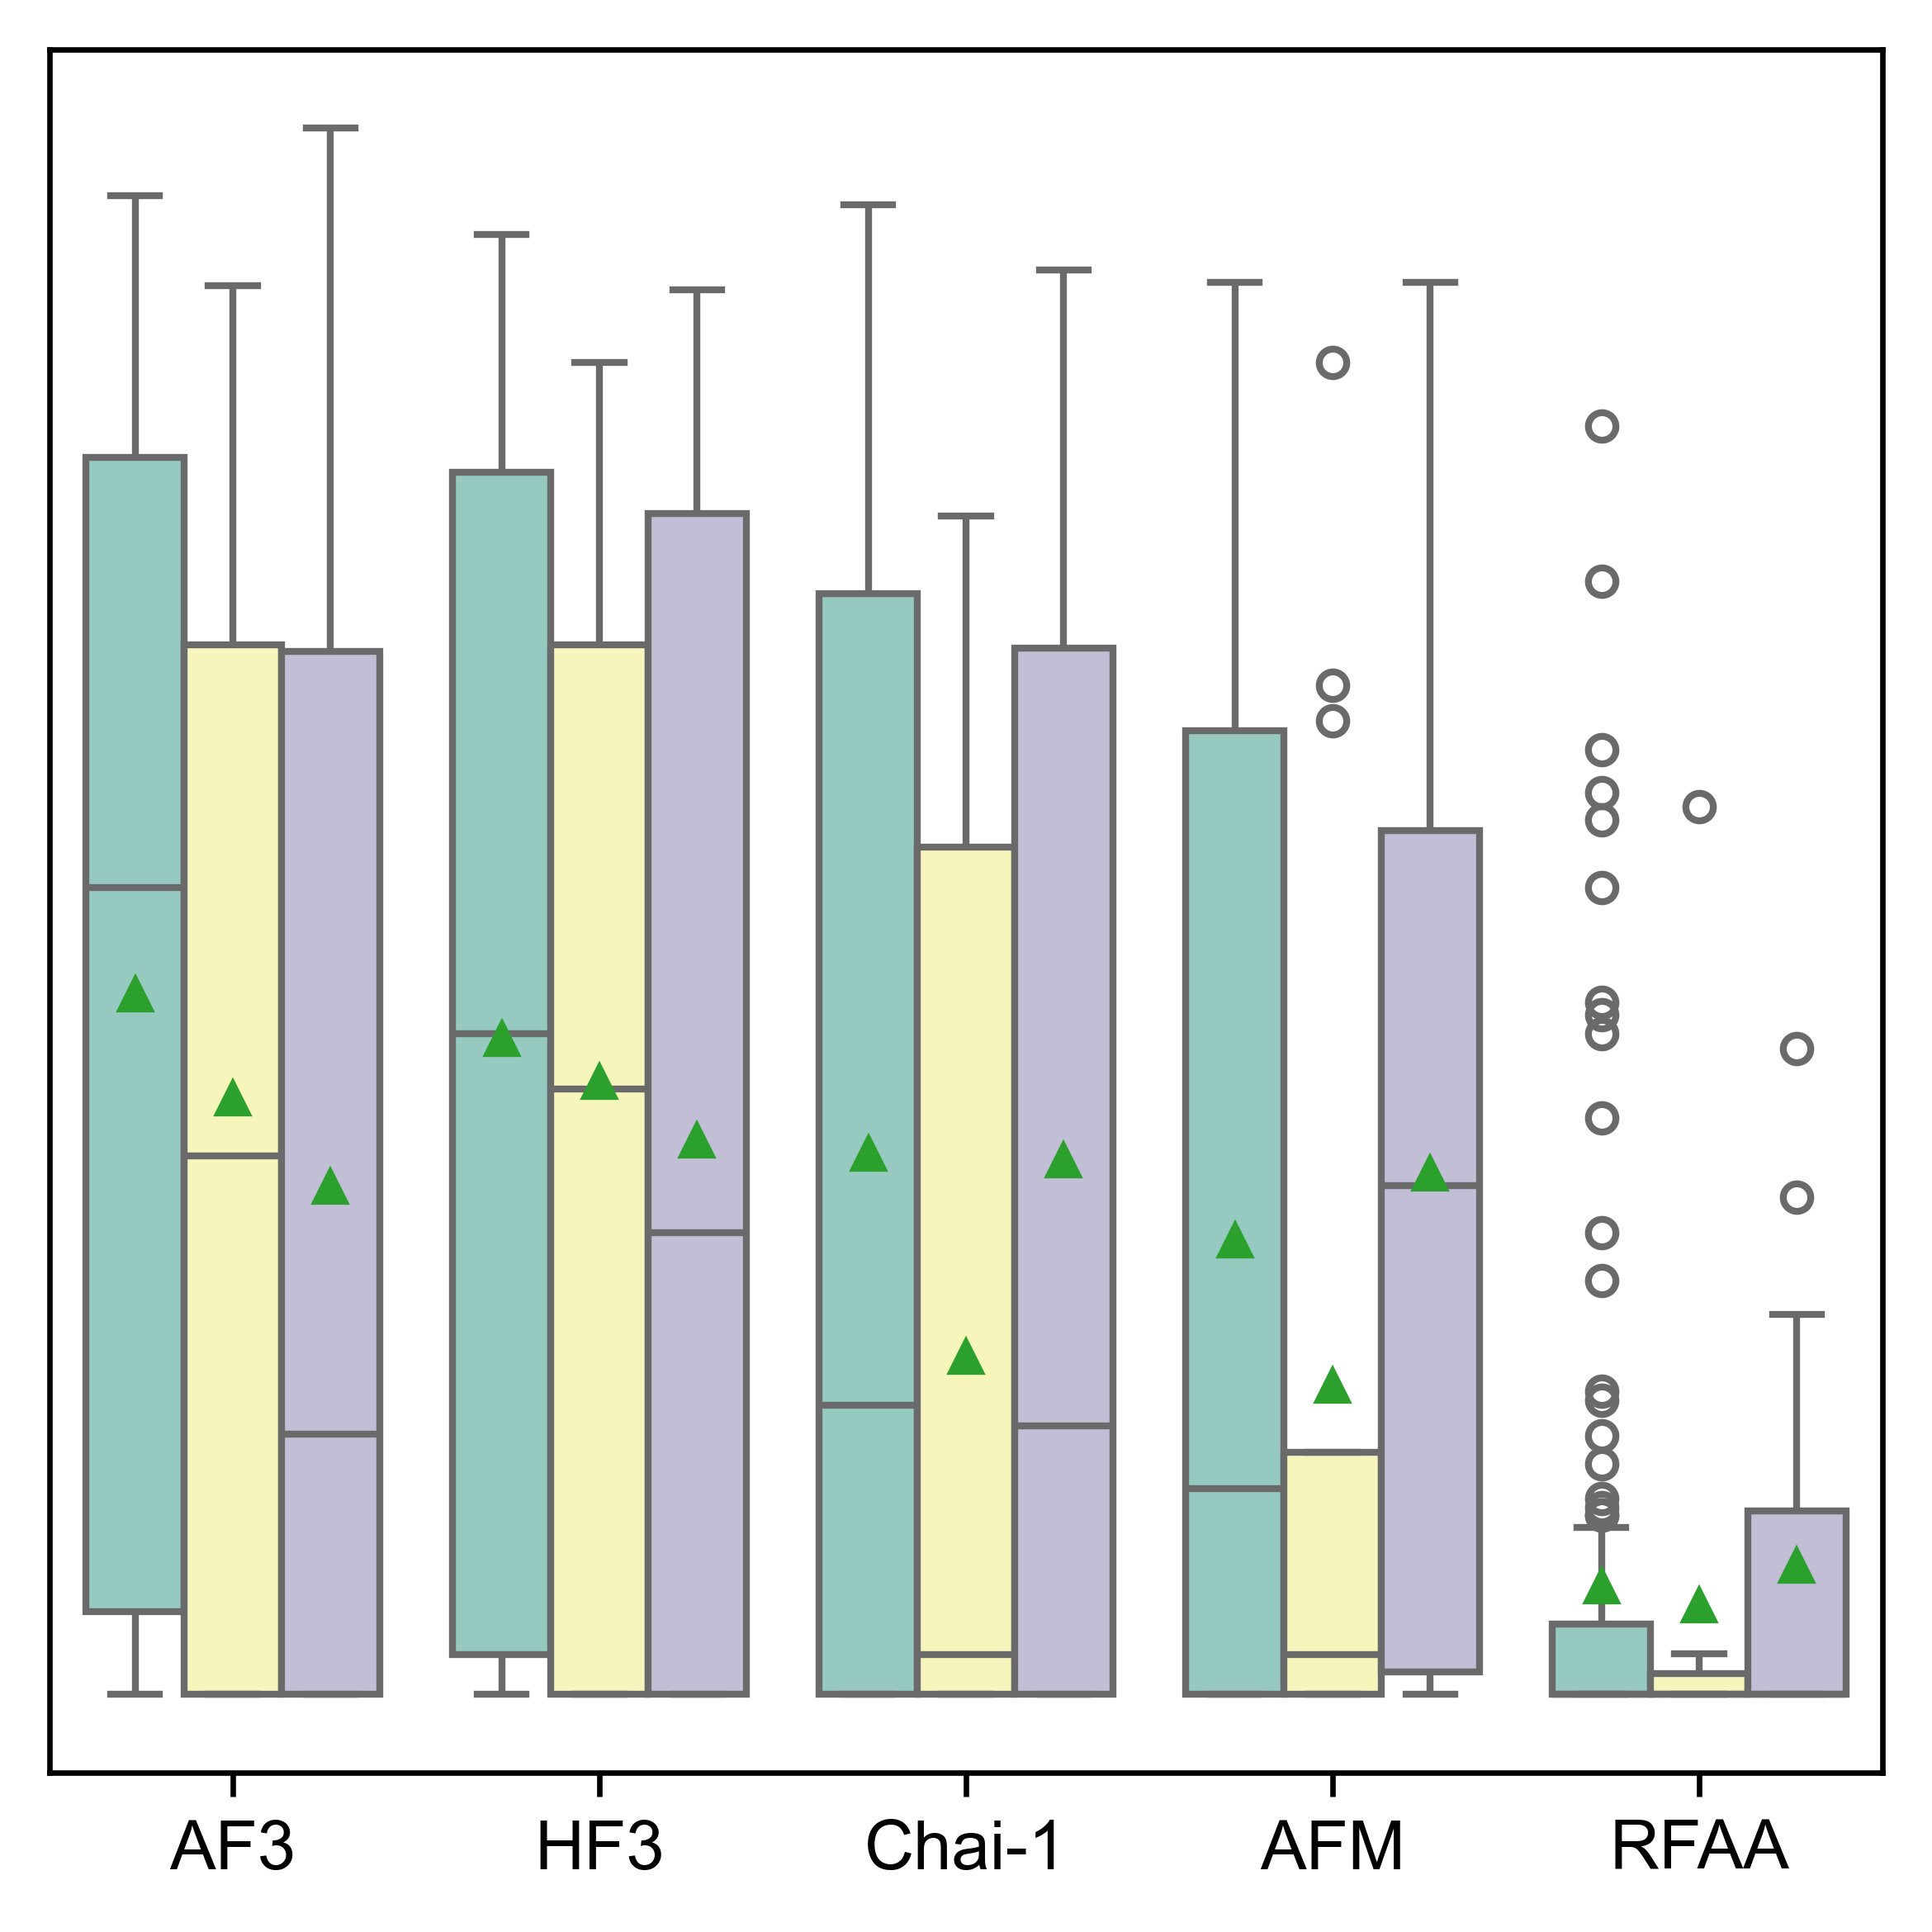

In [43]:
plot_dockq_with_pep_difficulty(coreset_df, "fnat")

In [40]:
def plot_dockq_with_pep_similarity(
    df: pd.DataFrame,
    metric="DockQ",
    seed_mode=False,
    similarity_order=["Full", "Core", "Train", "Test"],
    y_ticks = False
):
    """
    绘制不同模型在 Train / Test / Full 数据上的 DockQ 表现分布图。
    Full 是 Train 和 Test 的合并汇总。
    """
    ascending = metric in ["DockQ", "F1", "fnat"]
    result_list = []

    # 分别提取 Train / Test
    for model_name, model_group in df.groupby("model_name"):
        for job_name, job_group in model_group.groupby("job_name"):
            train_subset = job_group[job_group["similarity"] == "Train"].copy()
            if not train_subset.empty:
                result = {
                    "model_name": rename_dict.get(model_name, model_name),
                    "job_name": job_name,
                    "similarity": "Train",
                }
                if seed_mode:
                    scores = [
                        group[metric].sort_values(ascending=ascending).iloc[0]
                        for _, group in train_subset.groupby("seed")
                    ]
                    result[metric] = np.mean(scores)
                else:
                    result[metric] = train_subset[metric].sort_values(ascending=ascending).iloc[0]
                result_list.append(result)

            test_subset = job_group[job_group["similarity"] != "Train"].copy()
            if not test_subset.empty:
                result = {
                    "model_name": rename_dict.get(model_name, model_name),
                    "job_name": job_name,
                    "similarity": "Test",
                }
                if seed_mode:
                    scores = [
                        group[metric].sort_values(ascending=ascending).iloc[0]
                        for _, group in test_subset.groupby("seed")
                    ]
                    result[metric] = np.mean(scores)
                else:
                    result[metric] = test_subset[metric].sort_values(ascending=ascending).iloc[0]

                result_list.append(result)
            
            core_subset = job_group[job_group["similarity"] == "Core"].copy()
            if not core_subset.empty:
                result = {
                    "model_name": rename_dict.get(model_name, model_name),
                    "job_name": job_name,
                    "similarity": "Core",
                }
                if seed_mode:
                    scores = [
                        group[metric].sort_values(ascending=ascending).iloc[0]
                        for _, group in core_subset.groupby("seed")
                    ]
                    result[metric] = np.mean(scores)
                else:
                    result[metric] = core_subset[metric].sort_values(ascending=ascending).iloc[0]
                result_list.append(result)

            # 生成 Full = Train + Test 合并
            full_subset = job_group.copy()
            if not full_subset.empty:
                result = {
                    "model_name": rename_dict.get(model_name, model_name),
                    "job_name": job_name,
                    "similarity": "Full",
                }

                if seed_mode:
                    scores = [
                        group[metric].sort_values(ascending=ascending).iloc[0]
                        for _, group in full_subset.groupby("seed")
                    ]
                    result[metric] = np.mean(scores)
                else:
                    result[metric] = full_subset[metric].sort_values(ascending=ascending).iloc[0]

                result_list.append(result)
    
    print(len(result_list))
    # 转为 DataFrame
    result_df = pd.DataFrame(result_list)

    # 控制分组顺序
    result_df["similarity"] = pd.Categorical(result_df["similarity"], categories=similarity_order, ordered=True)

    # 按均值排序模型
    model_means = result_df.groupby("model_name")[metric].mean().sort_values(ascending=not ascending)
    result_df["model_name"] = pd.Categorical(result_df["model_name"], categories=model_means.index, ordered=True)

    # 输出统计信息
    stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])
    for model in stats.index:
        print(
            f"Model: {model}, "
            f"Mean {metric}: {stats.loc[model, 'mean']:.4f}, "
            f"Min: {stats.loc[model, 'min']:.4f}, "
            f"Max: {stats.loc[model, 'max']:.4f}, "
            f"Median: {stats.loc[model, 'median']:.4f}"
        )

    for seg in similarity_order:
        seg_df = result_df[result_df['similarity'] == seg]
        for model in stats.index:  
            print(model)
            seg_df_model = seg_df[seg_df['model_name'] == model]
            print(f"Mean {metric}: {seg_df_model[metric].mean()}")
            print(f"Median {metric}: {seg_df_model[metric].median()}")
            print(f"Min {metric}: {seg_df_model[metric].min()}")
            print(f"Max {metric}: {seg_df_model[metric].max()}")
            print("-----------")

    # 绘图
    fig, ax = plt.subplots(figsize=(4, 4), dpi=600)
    sns.boxplot(
        data=result_df,
        x="model_name",
        y=metric,
        hue="similarity",
        hue_order=similarity_order,
        palette="Set3",
        showmeans=True,
        ax=ax,
        boxprops=dict(alpha=1),
        whiskerprops=dict(alpha=1),
        capprops=dict(alpha=1),
        meanprops=dict(markersize=4),
        flierprops=dict(markersize=4),
    )

    # 美化图表
    # plt.legend(title="Similarity", loc="upper right", bbox_to_anchor=(1.2, 1))
    plt.legend().remove()
    plt.xlabel("")
    plt.ylabel("")
    if not y_ticks:
        plt.yticks([])
    # fig.patch.set_edgecolor('black')
    # fig.patch.set_linewidth(2.0)
    plt.tight_layout()
    plt.show()
    return result_df

In [41]:
fullset_df["similarity"] = fullset_df["redundency"].apply(lambda x: "Train" if x == 2 else "Test")
fullset_df.loc[fullset_df["redundency"] == 0, "similarity"] = "Core"

3346
Model: AF3, Mean DockQ: 0.5171, Min: 0.0068, Max: 0.9615, Median: 0.5965
Model: HF3, Mean DockQ: 0.5051, Min: 0.0050, Max: 0.9534, Median: 0.5739
Model: Chai-1, Mean DockQ: 0.4423, Min: 0.0029, Max: 0.9561, Median: 0.4399
Model: AFM, Mean DockQ: 0.4103, Min: 0.0065, Max: 0.9468, Median: 0.3255
Model: RFAA, Mean DockQ: 0.1413, Min: 0.0031, Max: 0.8778, Median: 0.0579
AF3
Mean DockQ: 0.5345092250683096
Median DockQ: 0.6363049110852941
Min DockQ: 0.0068244068407983
Max DockQ: 0.9615410627417076
-----------
HF3
Mean DockQ: 0.5224343745996202
Median DockQ: 0.5995810640347184
Min DockQ: 0.0049545386985102
Max DockQ: 0.9533943516548024
-----------
Chai-1
Mean DockQ: 0.45995587337275445
Median DockQ: 0.5087257711176678
Min DockQ: 0.0029222957553897
Max DockQ: 0.9561209262870146
-----------
AFM
Mean DockQ: 0.42555996695955794
Median DockQ: 0.34863526590038163
Min DockQ: 0.0065218666160421
Max DockQ: 0.946827617709549
-----------
RFAA
Mean DockQ: 0.14658103994725358
Median DockQ: 0.06126063

/tmp/ipykernel_3612396/1716929001.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


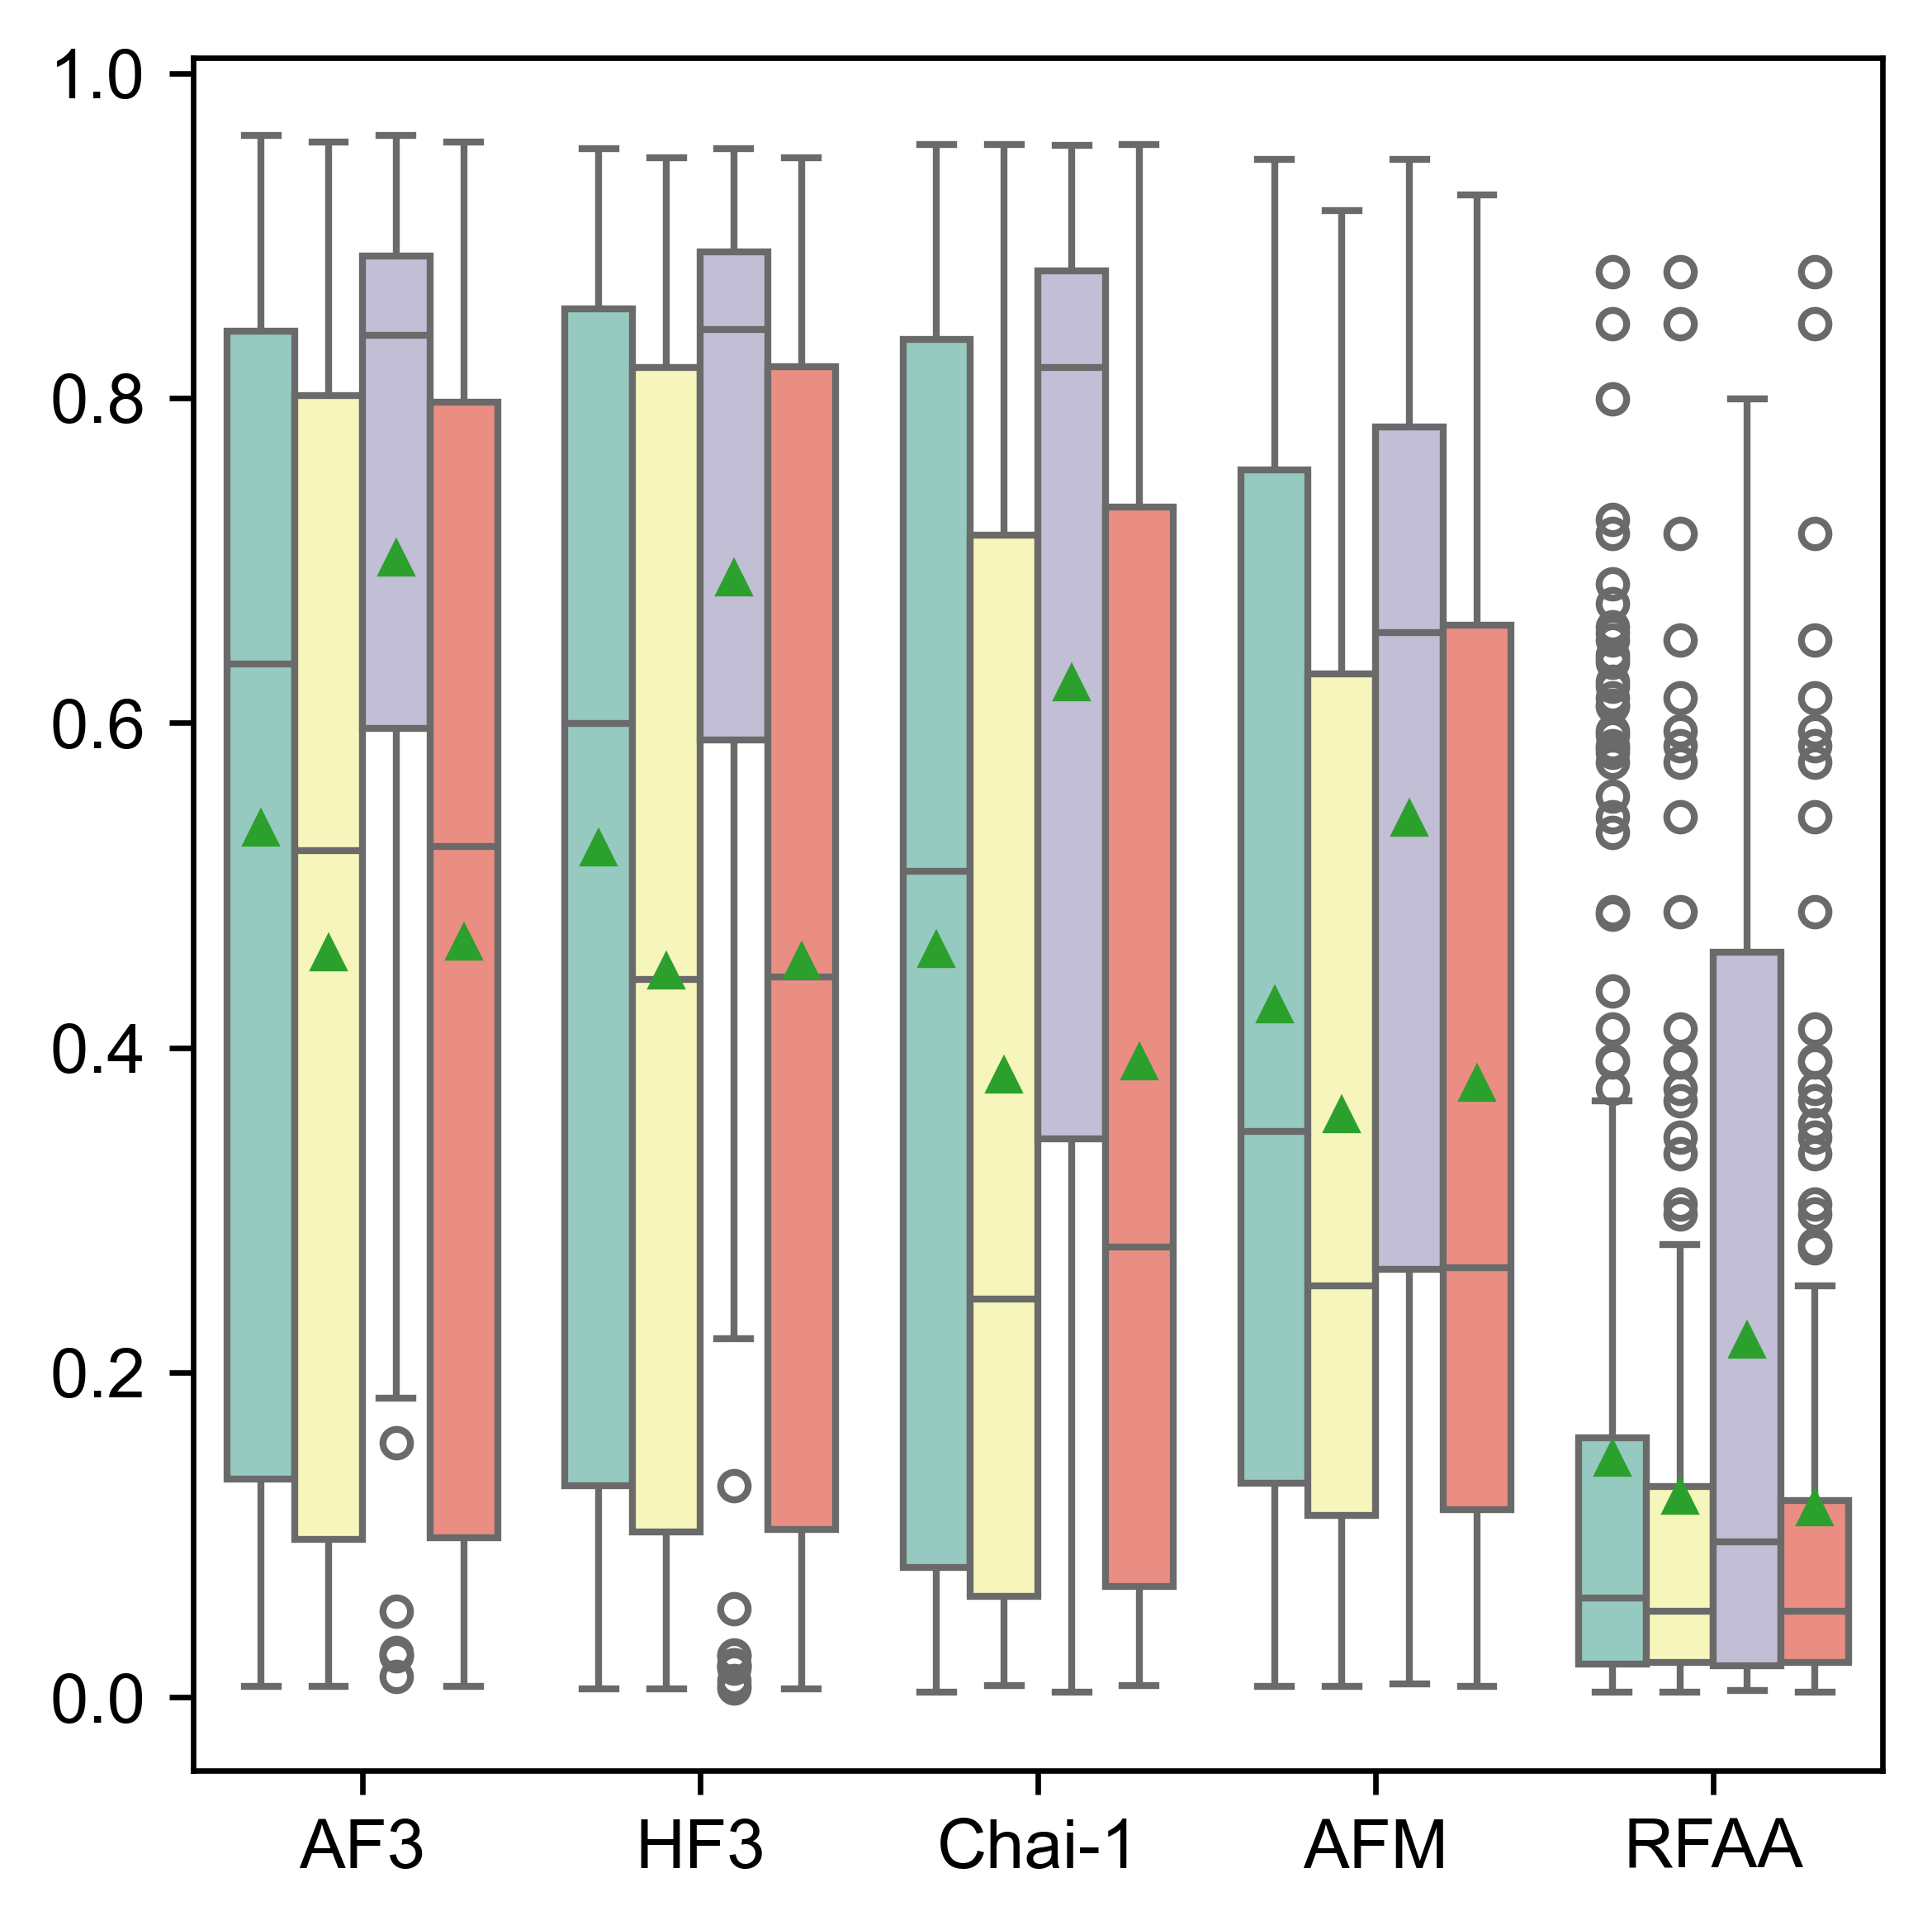

In [42]:
result_df = plot_dockq_with_pep_similarity(fullset_df, y_ticks=True)

In [33]:
print(sum(result_df["similarity"] == "Full"), sum(result_df["similarity"] == "Core"), sum(result_df["similarity"] == "Train"), sum(result_df["similarity"] == "Test"))

1293 760 383 910


3346
Model: AF3, Mean LRMSD: 10.0060, Min: 0.5520, Max: 63.9073, Median: 3.7282
Model: AFM, Mean LRMSD: 11.3749, Min: 0.5294, Max: 64.5621, Median: 6.9031
Model: HF3, Mean LRMSD: 11.5730, Min: 0.5449, Max: 75.7402, Median: 4.3920
Model: Chai-1, Mean LRMSD: 13.0672, Min: 0.7063, Max: 98.4302, Median: 6.6786
Model: RFAA, Mean LRMSD: 26.1103, Min: 1.0211, Max: 94.3385, Median: 22.8581


/tmp/ipykernel_3612396/3975424047.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


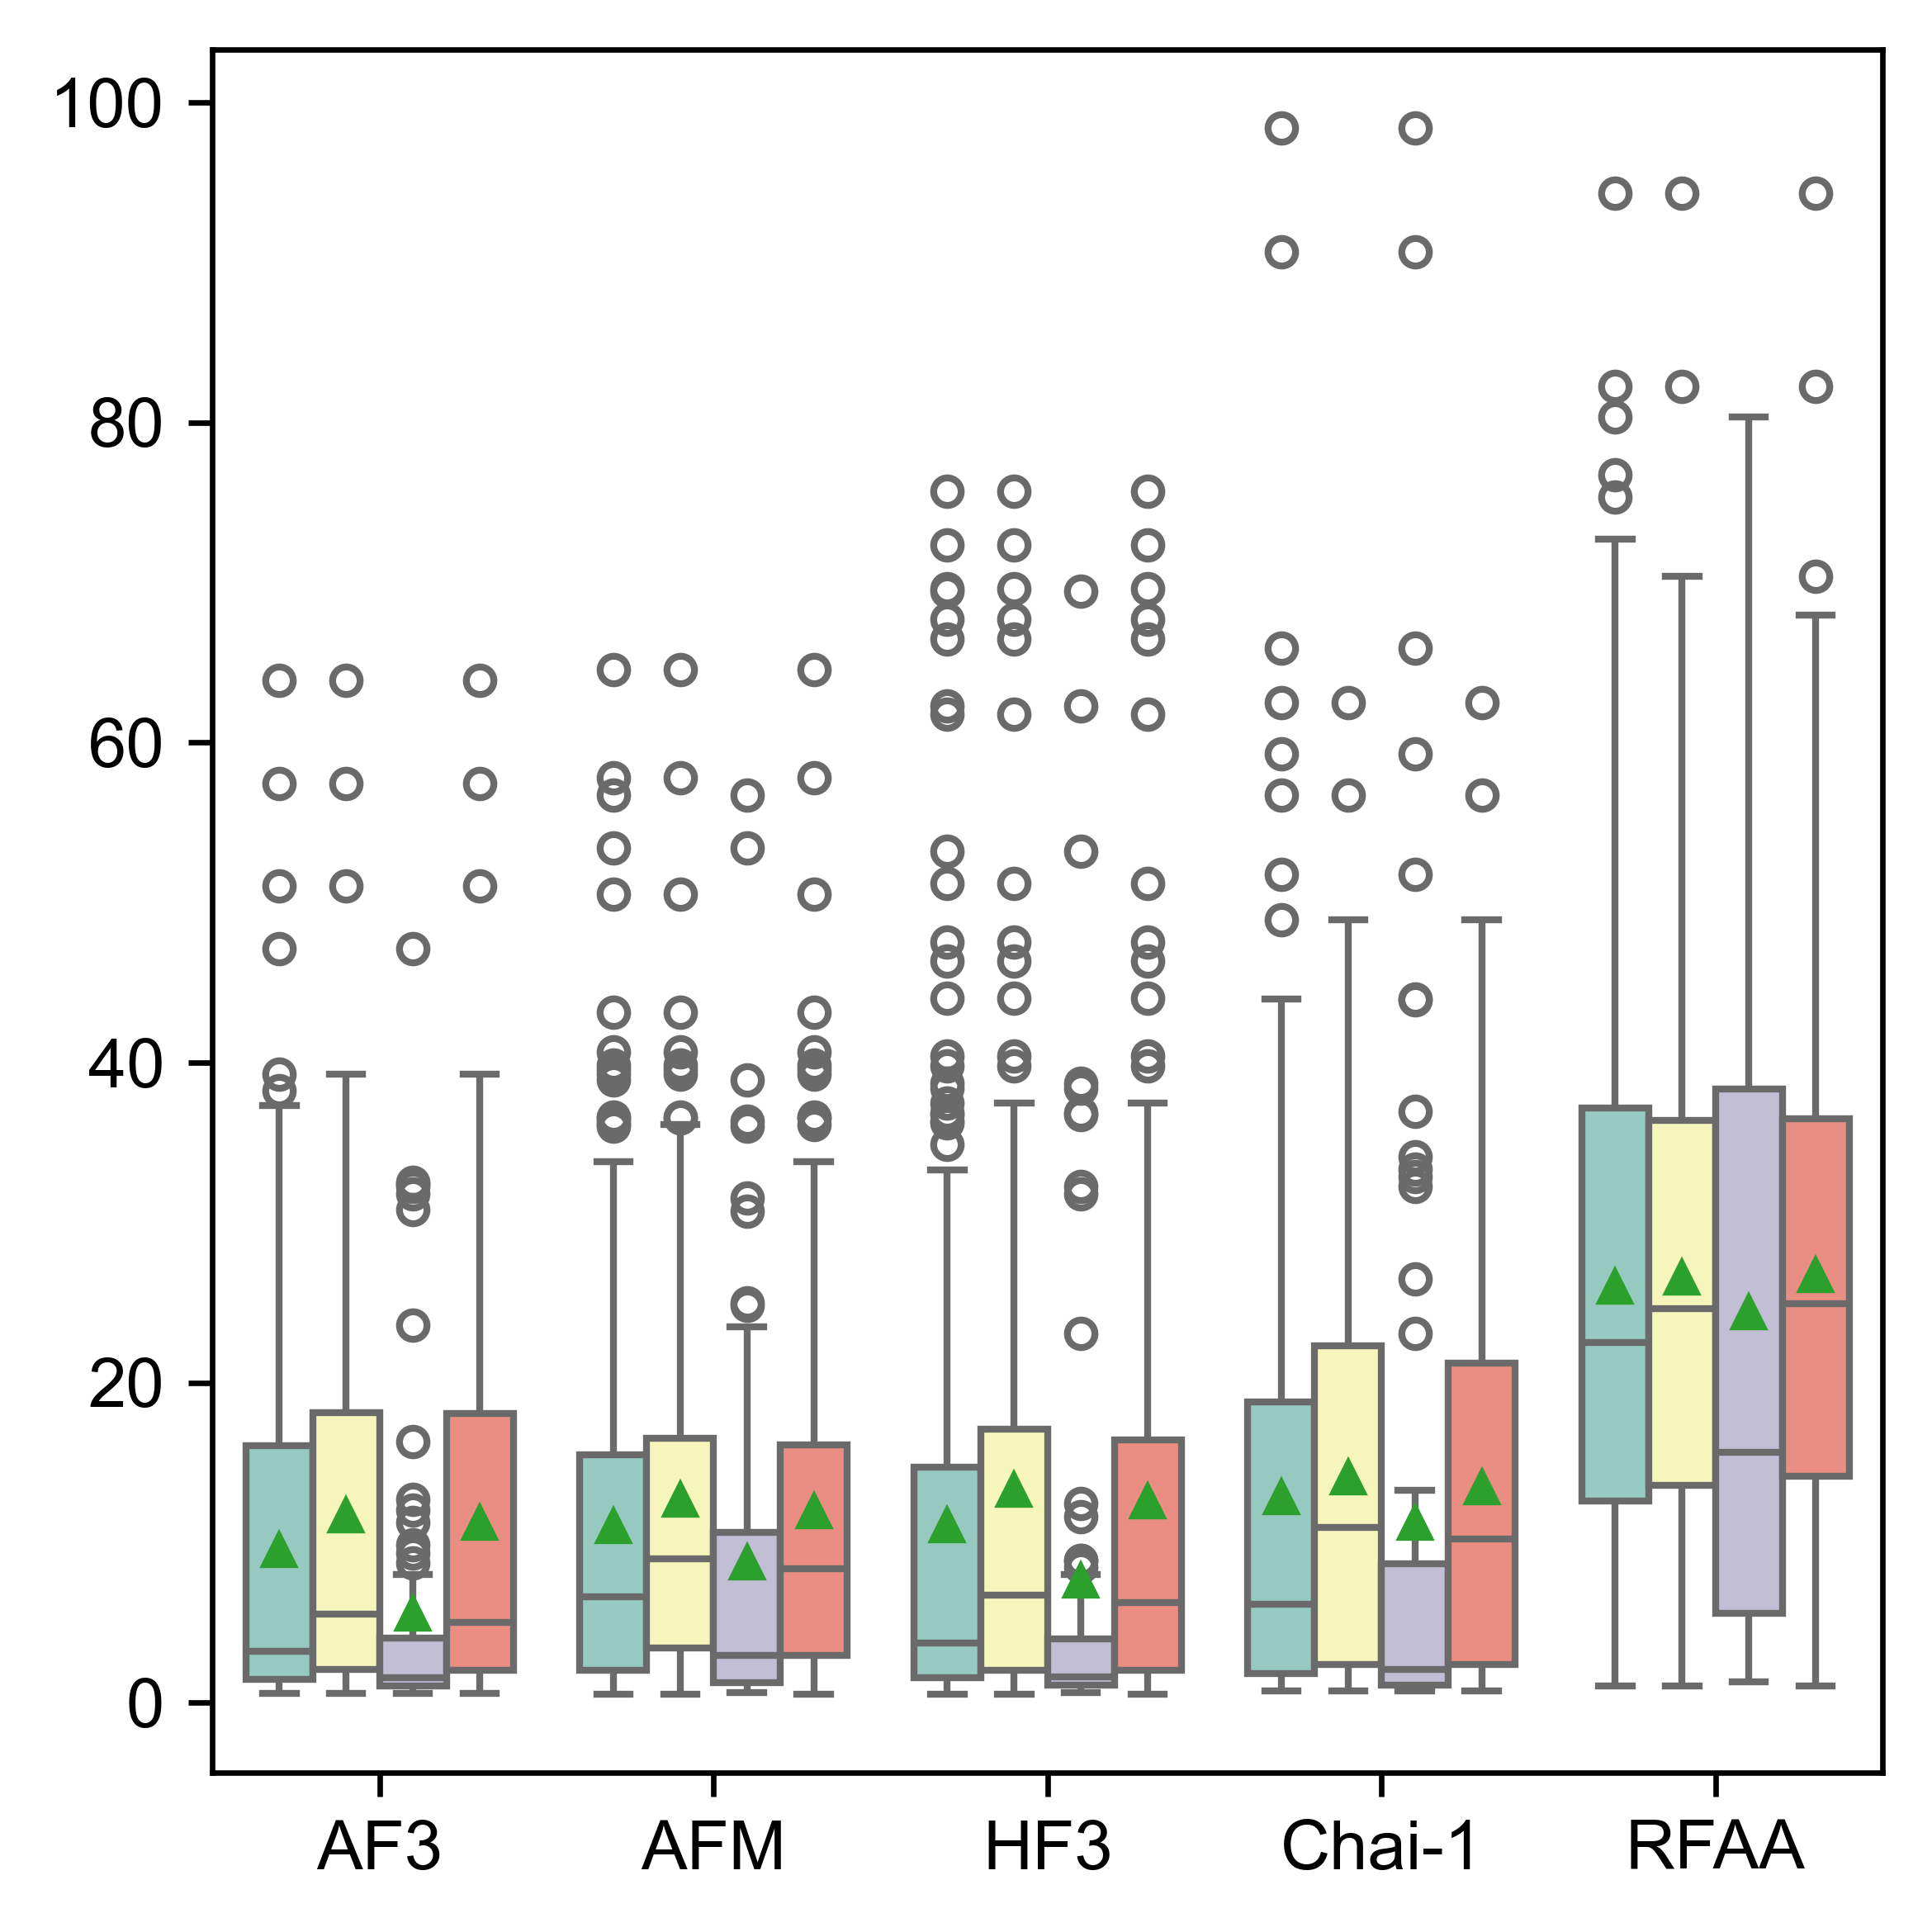

,model_name,job_name,similarity,LRMSD
0,AF3,8c5l_C,Test,34.247372
1,AF3,8c5l_C,Core,34.247372
2,AF3,8c5l_C,Full,34.247372
3,AF3,8ccz_C,Test,27.887942
4,AF3,8ccz_C,Core,27.887942
...,...,...,...,...
3341,RFAA,9g13_B,Test,36.155729
3342,RFAA,9g13_B,Core,36.155729
3343,RFAA,9g13_B,Full,36.155729
3344,RFAA,9gag_B,Train,31.486124


In [34]:
plot_dockq_with_pep_similarity(fullset_df, "LRMSD", y_ticks=True)

3346
Model: AF3, Mean fnat: 0.4755, Min: 0.0000, Max: 0.9706, Median: 0.6207
Model: HF3, Mean fnat: 0.4582, Min: 0.0000, Max: 0.9565, Median: 0.6341
Model: Chai-1, Mean fnat: 0.3891, Min: 0.0000, Max: 0.9600, Median: 0.4118
Model: AFM, Mean fnat: 0.3350, Min: 0.0000, Max: 0.8810, Median: 0.1852
Model: RFAA, Mean fnat: 0.0842, Min: 0.0000, Max: 0.7857, Median: 0.0000


/tmp/ipykernel_3612396/3975424047.py:102: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats = result_df.groupby("model_name")[metric].agg(["mean", "min", "max", "median"])


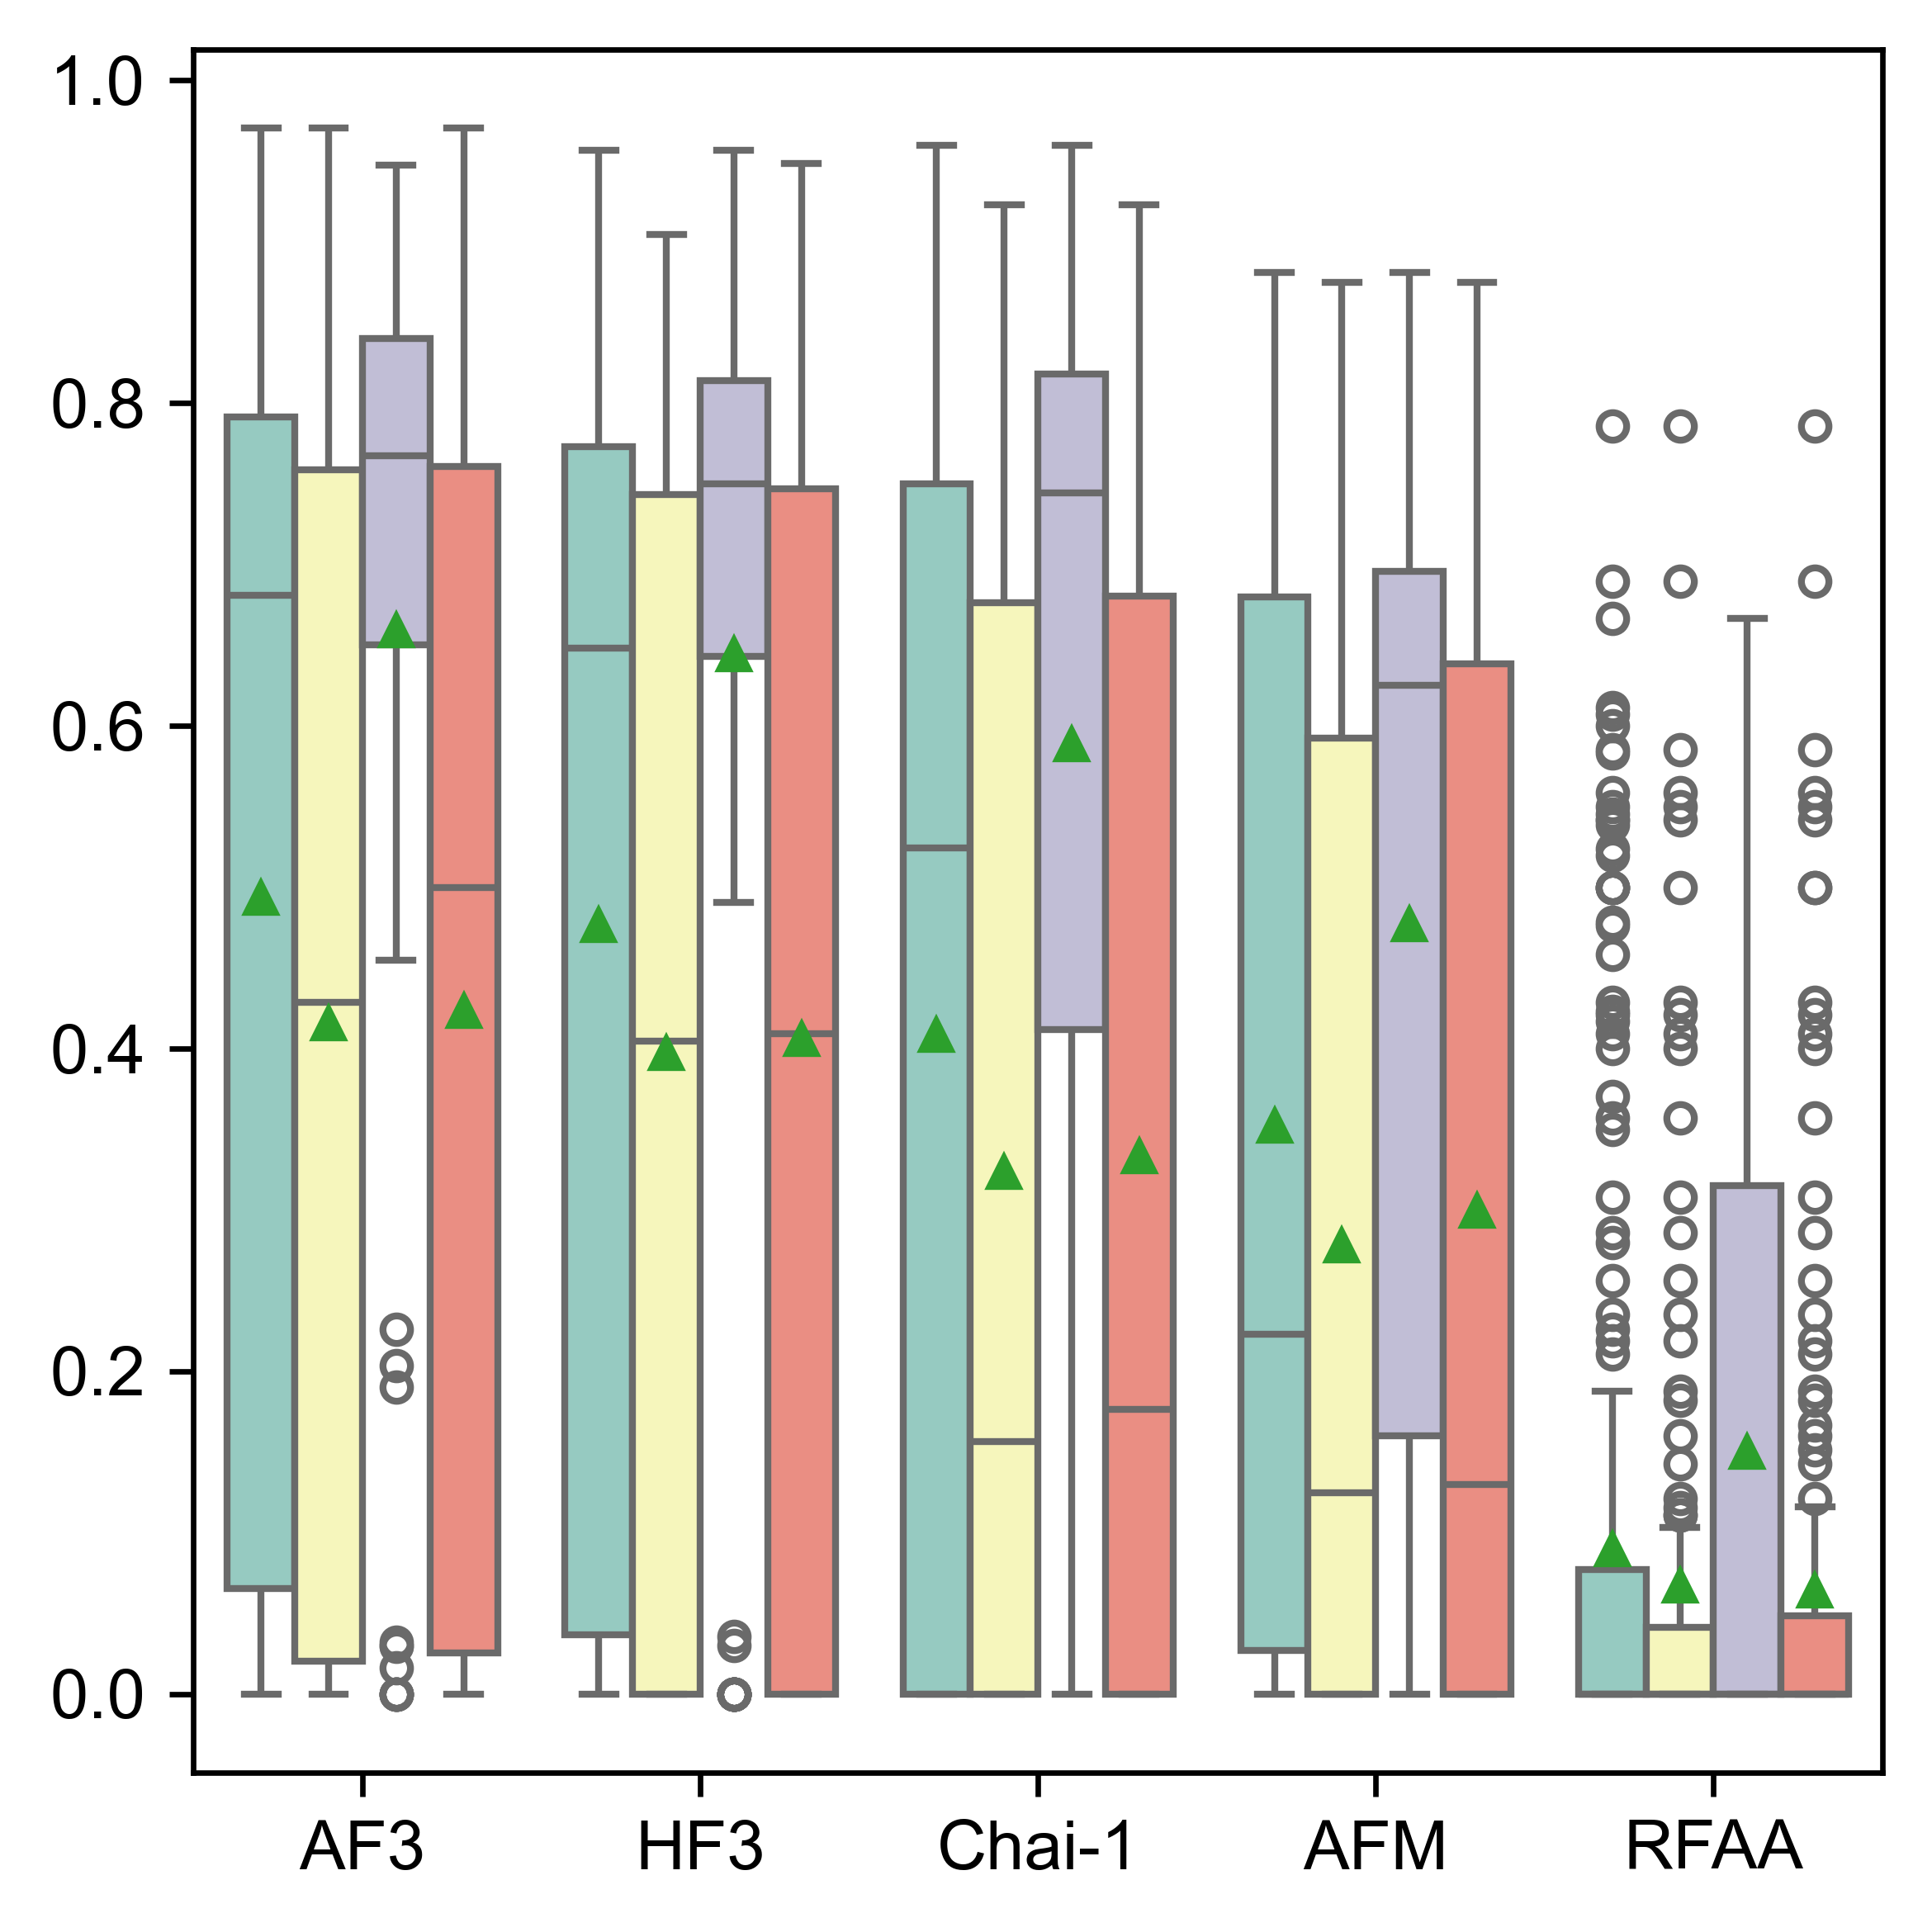

,model_name,job_name,similarity,fnat
0,AF3,8c5l_C,Test,0.000000
1,AF3,8c5l_C,Core,0.000000
2,AF3,8c5l_C,Full,0.000000
3,AF3,8ccz_C,Test,0.236842
4,AF3,8ccz_C,Core,0.236842
...,...,...,...,...
3341,RFAA,9g13_B,Test,0.000000
3342,RFAA,9g13_B,Core,0.000000
3343,RFAA,9g13_B,Full,0.000000
3344,RFAA,9gag_B,Train,0.000000


In [35]:
plot_dockq_with_pep_similarity(fullset_df, "fnat", y_ticks=True)